<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 3: прогнозирование временных рядов</center></h2>

In [158]:
%%capture
!pip install -r https://raw.githubusercontent.com/hse-ds/iad-applied-ds/master/2023/hw/hw3/requirements.txt

In [159]:
import warnings
import gdown
import pandas as pd
import numpy as np
import seaborn as sns
from copy import deepcopy

warnings.filterwarnings("ignore")

В данной задаче мы будем решать одну из актуальных практических задач, с которыми, в том числе, сталкиваются разработчики ETNA - прогнозирование объема необходимой наличности в банкоматах (на примере одного устройства). Пожалуй, ни для кого не секрет, что отсутствие необходимой суммы в банкомате не делает клиента банка счастливее. В то же время, избыток заправленной в банкомат наличности приводит к упущенной выгоде - ведь, в конечном счете, эти деньги могли быть размещены в качестве краткосрочного депозита на межбанковском рынке. Для кредитной организации с обширной сетью банкоматов даже незначительное улучшение качества предсказания способно внести значительный вклад в прибыльность этой ветки бизнеса. 

Мы будем использовать дневные данные реального банкомата хоть и не с российского рынка, но очень схожего с ним - турецкого. Скачаем и загрузим их:

In [ ]:
url = 'https://raw.githubusercontent.com/andrei-egorov/ml_se_seminars/master/atm_daily_cash.csv'
output = 'atm_daily_cash.csv'
gdown.download(url=url, output=output, quiet=False, fuzzy=True)

df = pd.read_csv('atm_daily_cash.csv')
df = df[4:] #лучше избавиться от нескольких пропущенных значений в начале сразу,
            #могут доставлять ненужные лишние проблемы

Взглянем на то, что представляют из себя данные:

In [161]:
df.head()

Date   CashIn  CashOut
4  1/5/2016  20840.0  22200.0
5  1/6/2016  28460.0  18810.0
6  1/7/2016  19250.0  23210.0
7  1/8/2016  49770.0   4350.0
8  1/9/2016      NaN      NaN

В нашем распоряжении пополнения и изъятия; нас интересует нетто. Для этого будем учитывать изъятия со знаком минус, а нетто определим как сумму (такое представление пригодится нам в дальнейшем).

In [162]:
df['CashOut'] = -df['CashOut']
df['target'] = df['CashIn'] + df['CashOut']

### Задание 1. EDA (1 балл)

Проведите разведывательный анализ данных - постройте графики, на которых можно судить о наличии тренда, сезонности и прочих зависимостей. Проанализируйте корреляции. Какие выводы вы можете сделать?

In [163]:
from matplotlib import pyplot as plt
import datetime
import calendar

Функция для приведения дат к числовому виду

In [164]:
def tonum(date, pivot_y=2010, pivot_m=1):
  m, d, y = date.split('/')
  return (datetime.date(int(y), int(m), int(d)) - datetime.date(pivot_y, pivot_m, 1)).days

Функция для определения дня недели по дате

In [165]:
def toweekday(date):
  m, d, y = date.split('/')
  return datetime.date(int(y), int(m), int(d)).weekday()

Создаю колонки с новым обозначением дат, с годом, месяцем и днём

In [166]:
df['DDate'] = df['Date'].apply(tonum) - min(df['Date'].apply(tonum))
df['Year'] = df['Date'].apply(lambda x: int(x.split('/')[2]))
df['Month'] = df['Date'].apply(lambda x: int(x.split('/')[0]))
df['Day'] = df['Date'].apply(lambda x: int(x.split('/')[1]))

Строю простой график

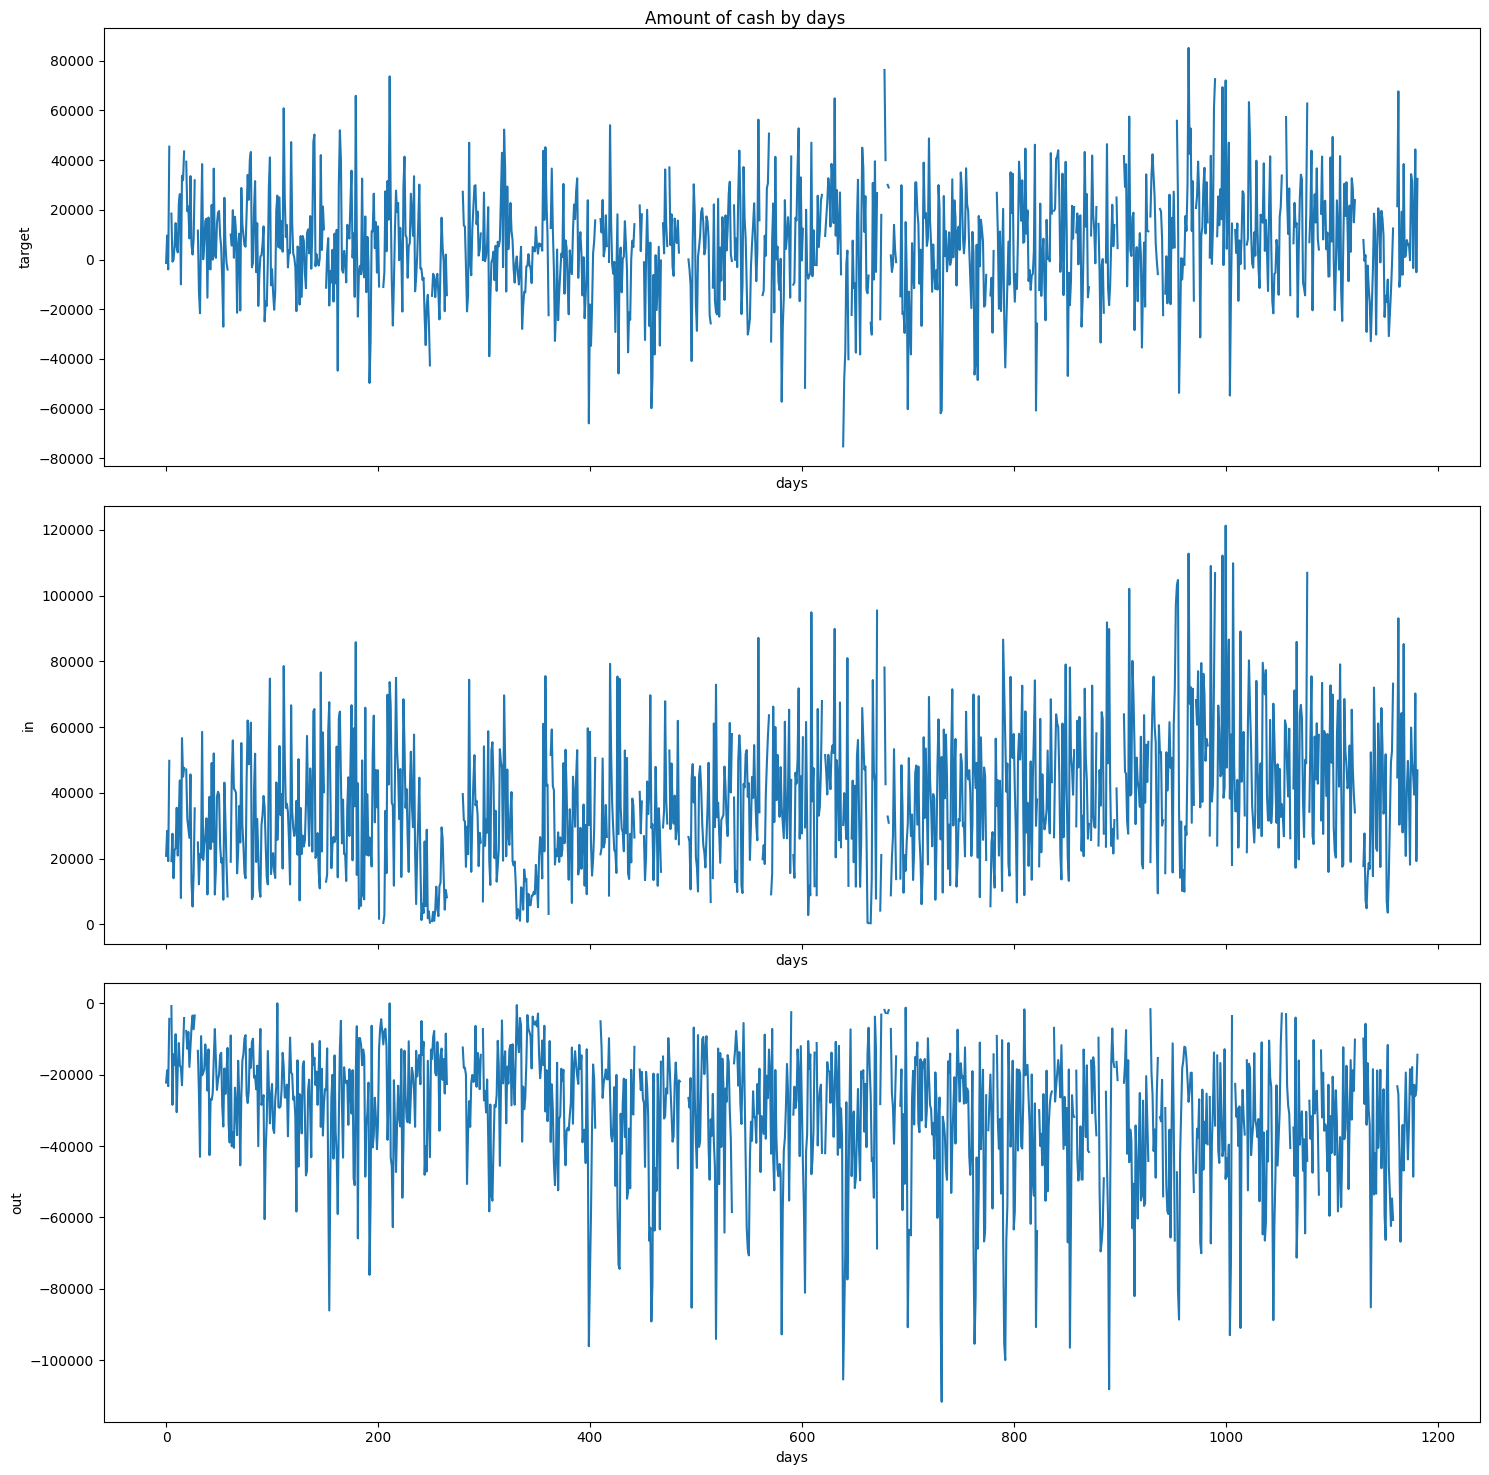

In [167]:
fig, ((ax1), (ax2), (ax3)) = plt.subplots(3, 1, sharex=True, figsize=(15,15))
ax1.plot(df.DDate, df.target, label='tagret')
ax1.set_ylabel('target')
ax1.set_xlabel('days')

ax2.plot(df.DDate, df.CashIn, label='in')
ax2.set_ylabel('in')
ax2.set_xlabel('days')

ax3.plot(df.DDate, df.CashOut, label='out')
ax3.set_ylabel('out')
ax3.set_xlabel('days')

fig.suptitle('Amount of cash by days')
fig.tight_layout()
fig.show()

По этому графику сложно определить какие-либо сезонности или тренд, пробую смотреть более дробно

In [168]:
years = np.unique(df['Year'].values)
years

array([2016, 2017, 2018, 2019])

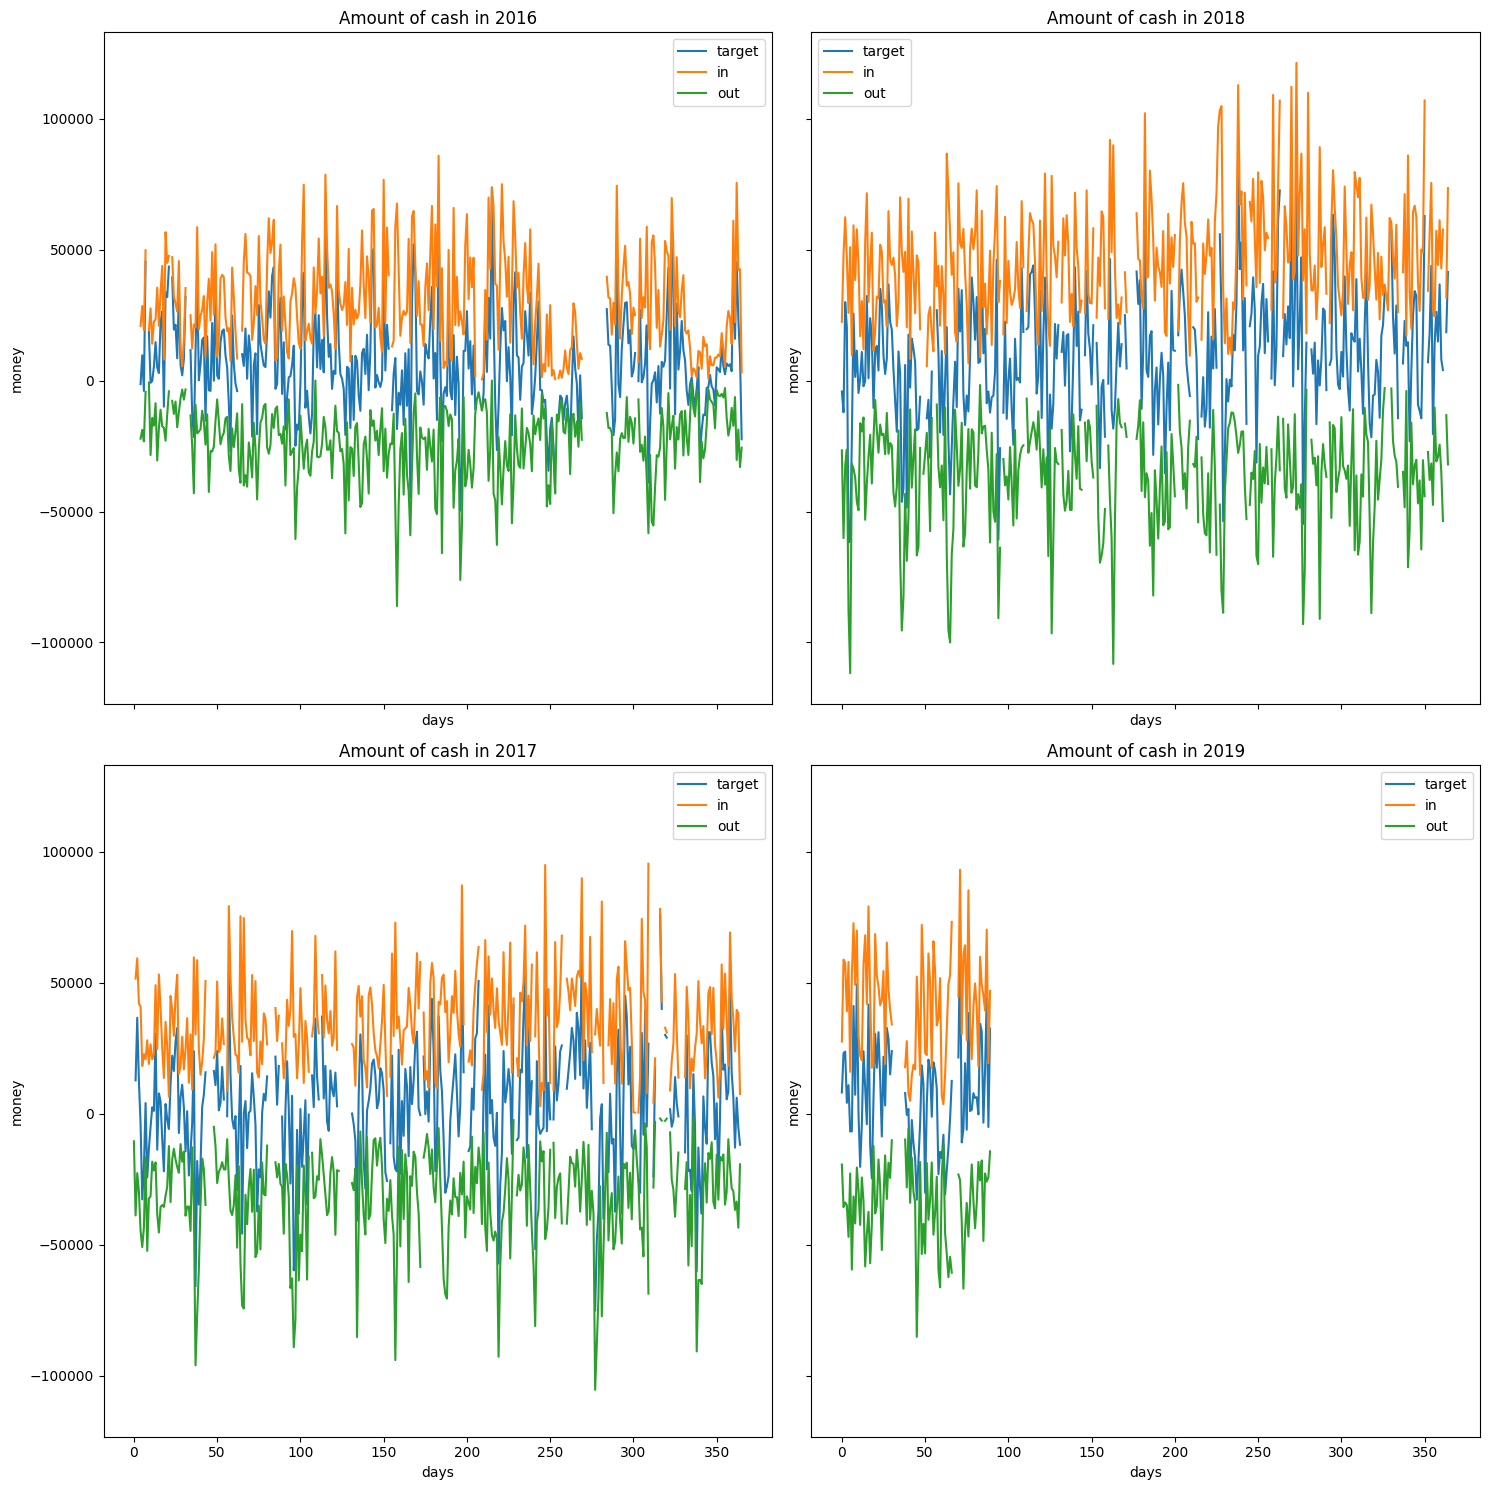

In [169]:
fig, plots = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(15,15))
for i in range(len(years)):
  year_data = df[df['Year'] == years[i]]
  days = (year_data['Date'].apply(lambda x: tonum(x, years[i]))).values
  plots[i%2, i//2].plot(days, year_data.target, label="target")
  plots[i%2, i//2].plot(days, year_data.CashIn, label='in')
  plots[i%2, i//2].plot(days, year_data.CashOut, label='out')
  plots[i%2, i//2].legend()
  plots[i%2, i//2].set_ylabel('money')
  plots[i%2, i//2].set_xlabel('days')
  plots[i%2, i//2].set_title(f'Amount of cash in {years[i]}')
fig.tight_layout()
fig.show()

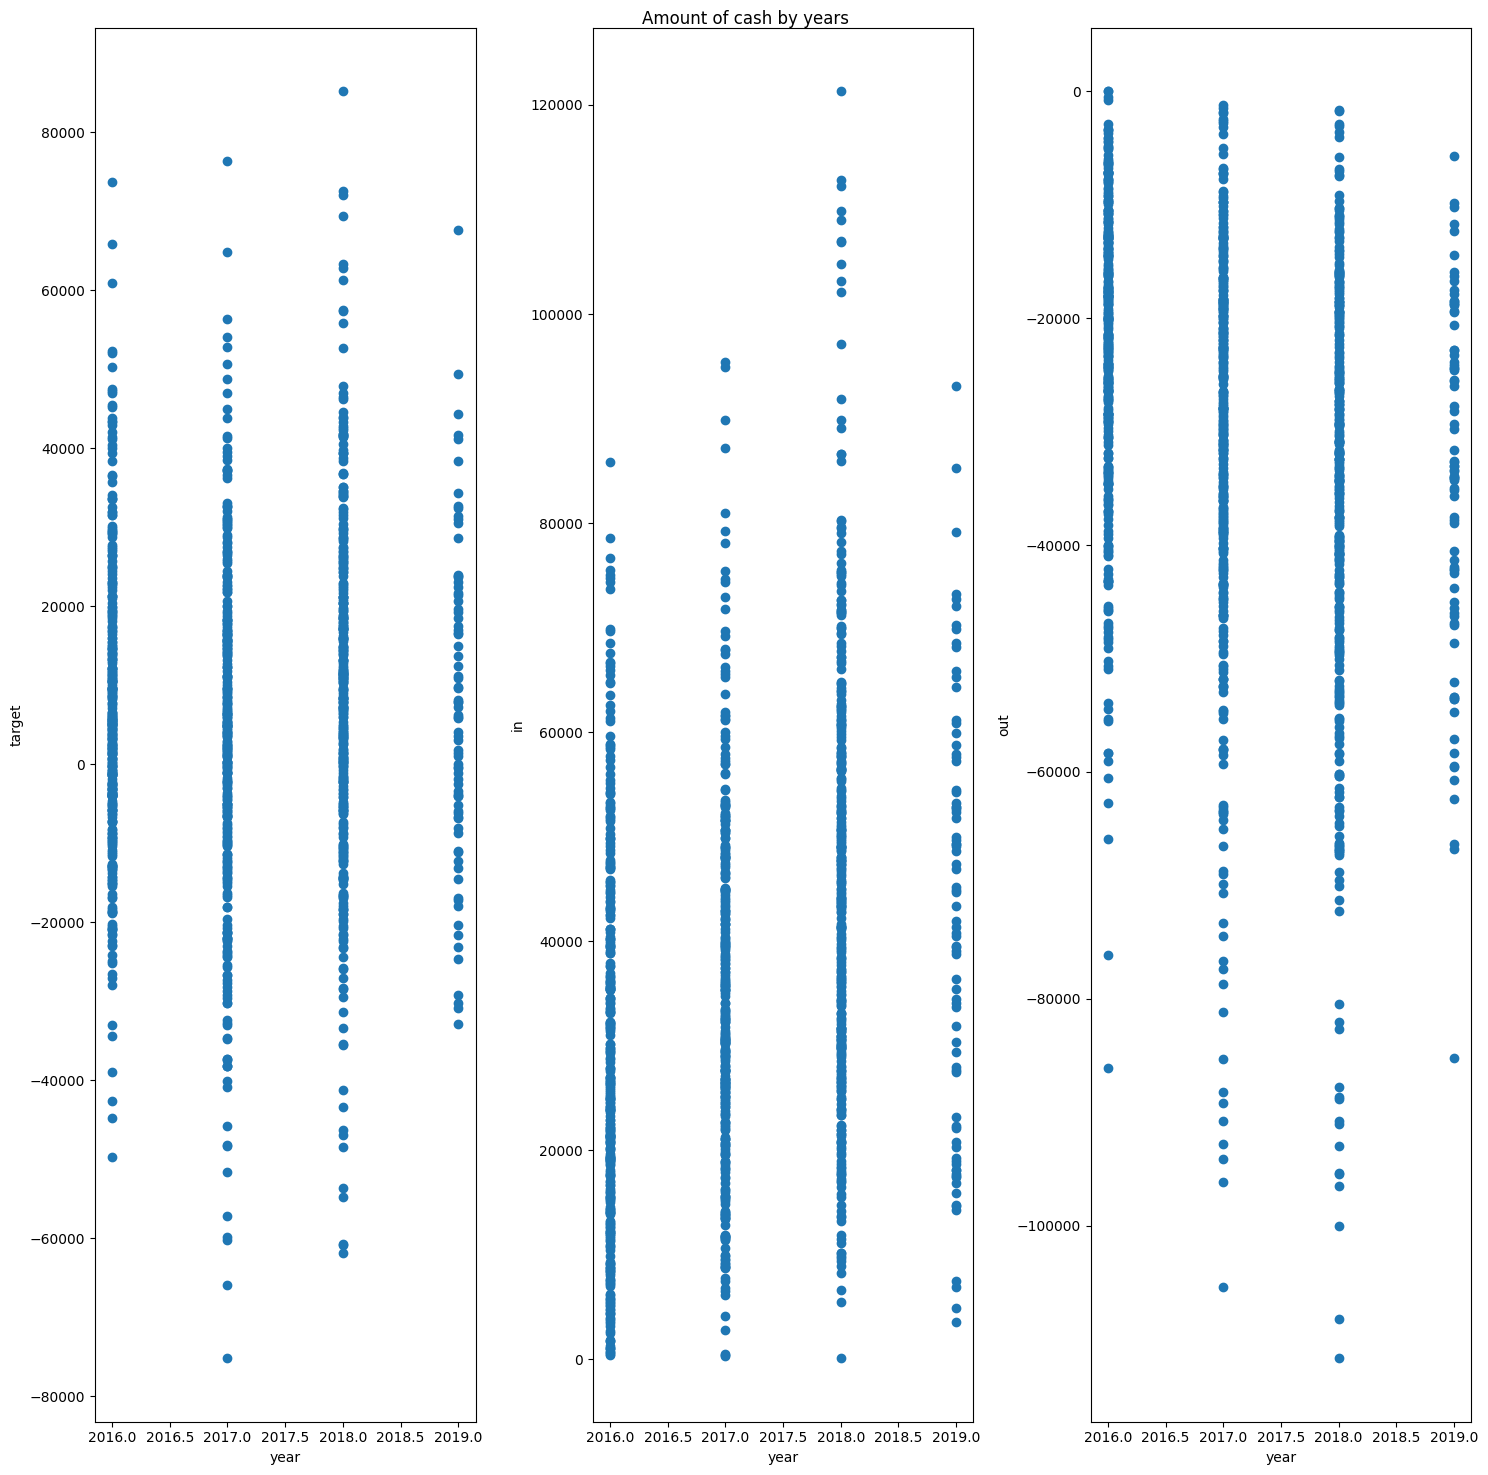

In [170]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, figsize=(15,15))
ax1.scatter(df['Year'], df['target'])
ax1.set_ylabel('target')
ax1.set_xlabel('year')

ax2.scatter(df['Year'], df['CashIn'])
ax2.set_ylabel('in')
ax2.set_xlabel('year')

ax3.scatter(df['Year'], df['CashOut'])
ax3.set_ylabel('out')
ax3.set_xlabel('year')

fig.suptitle('Amount of cash by years')
fig.tight_layout()
fig.show()

Здесь также довольно трудно что-то определить визуально

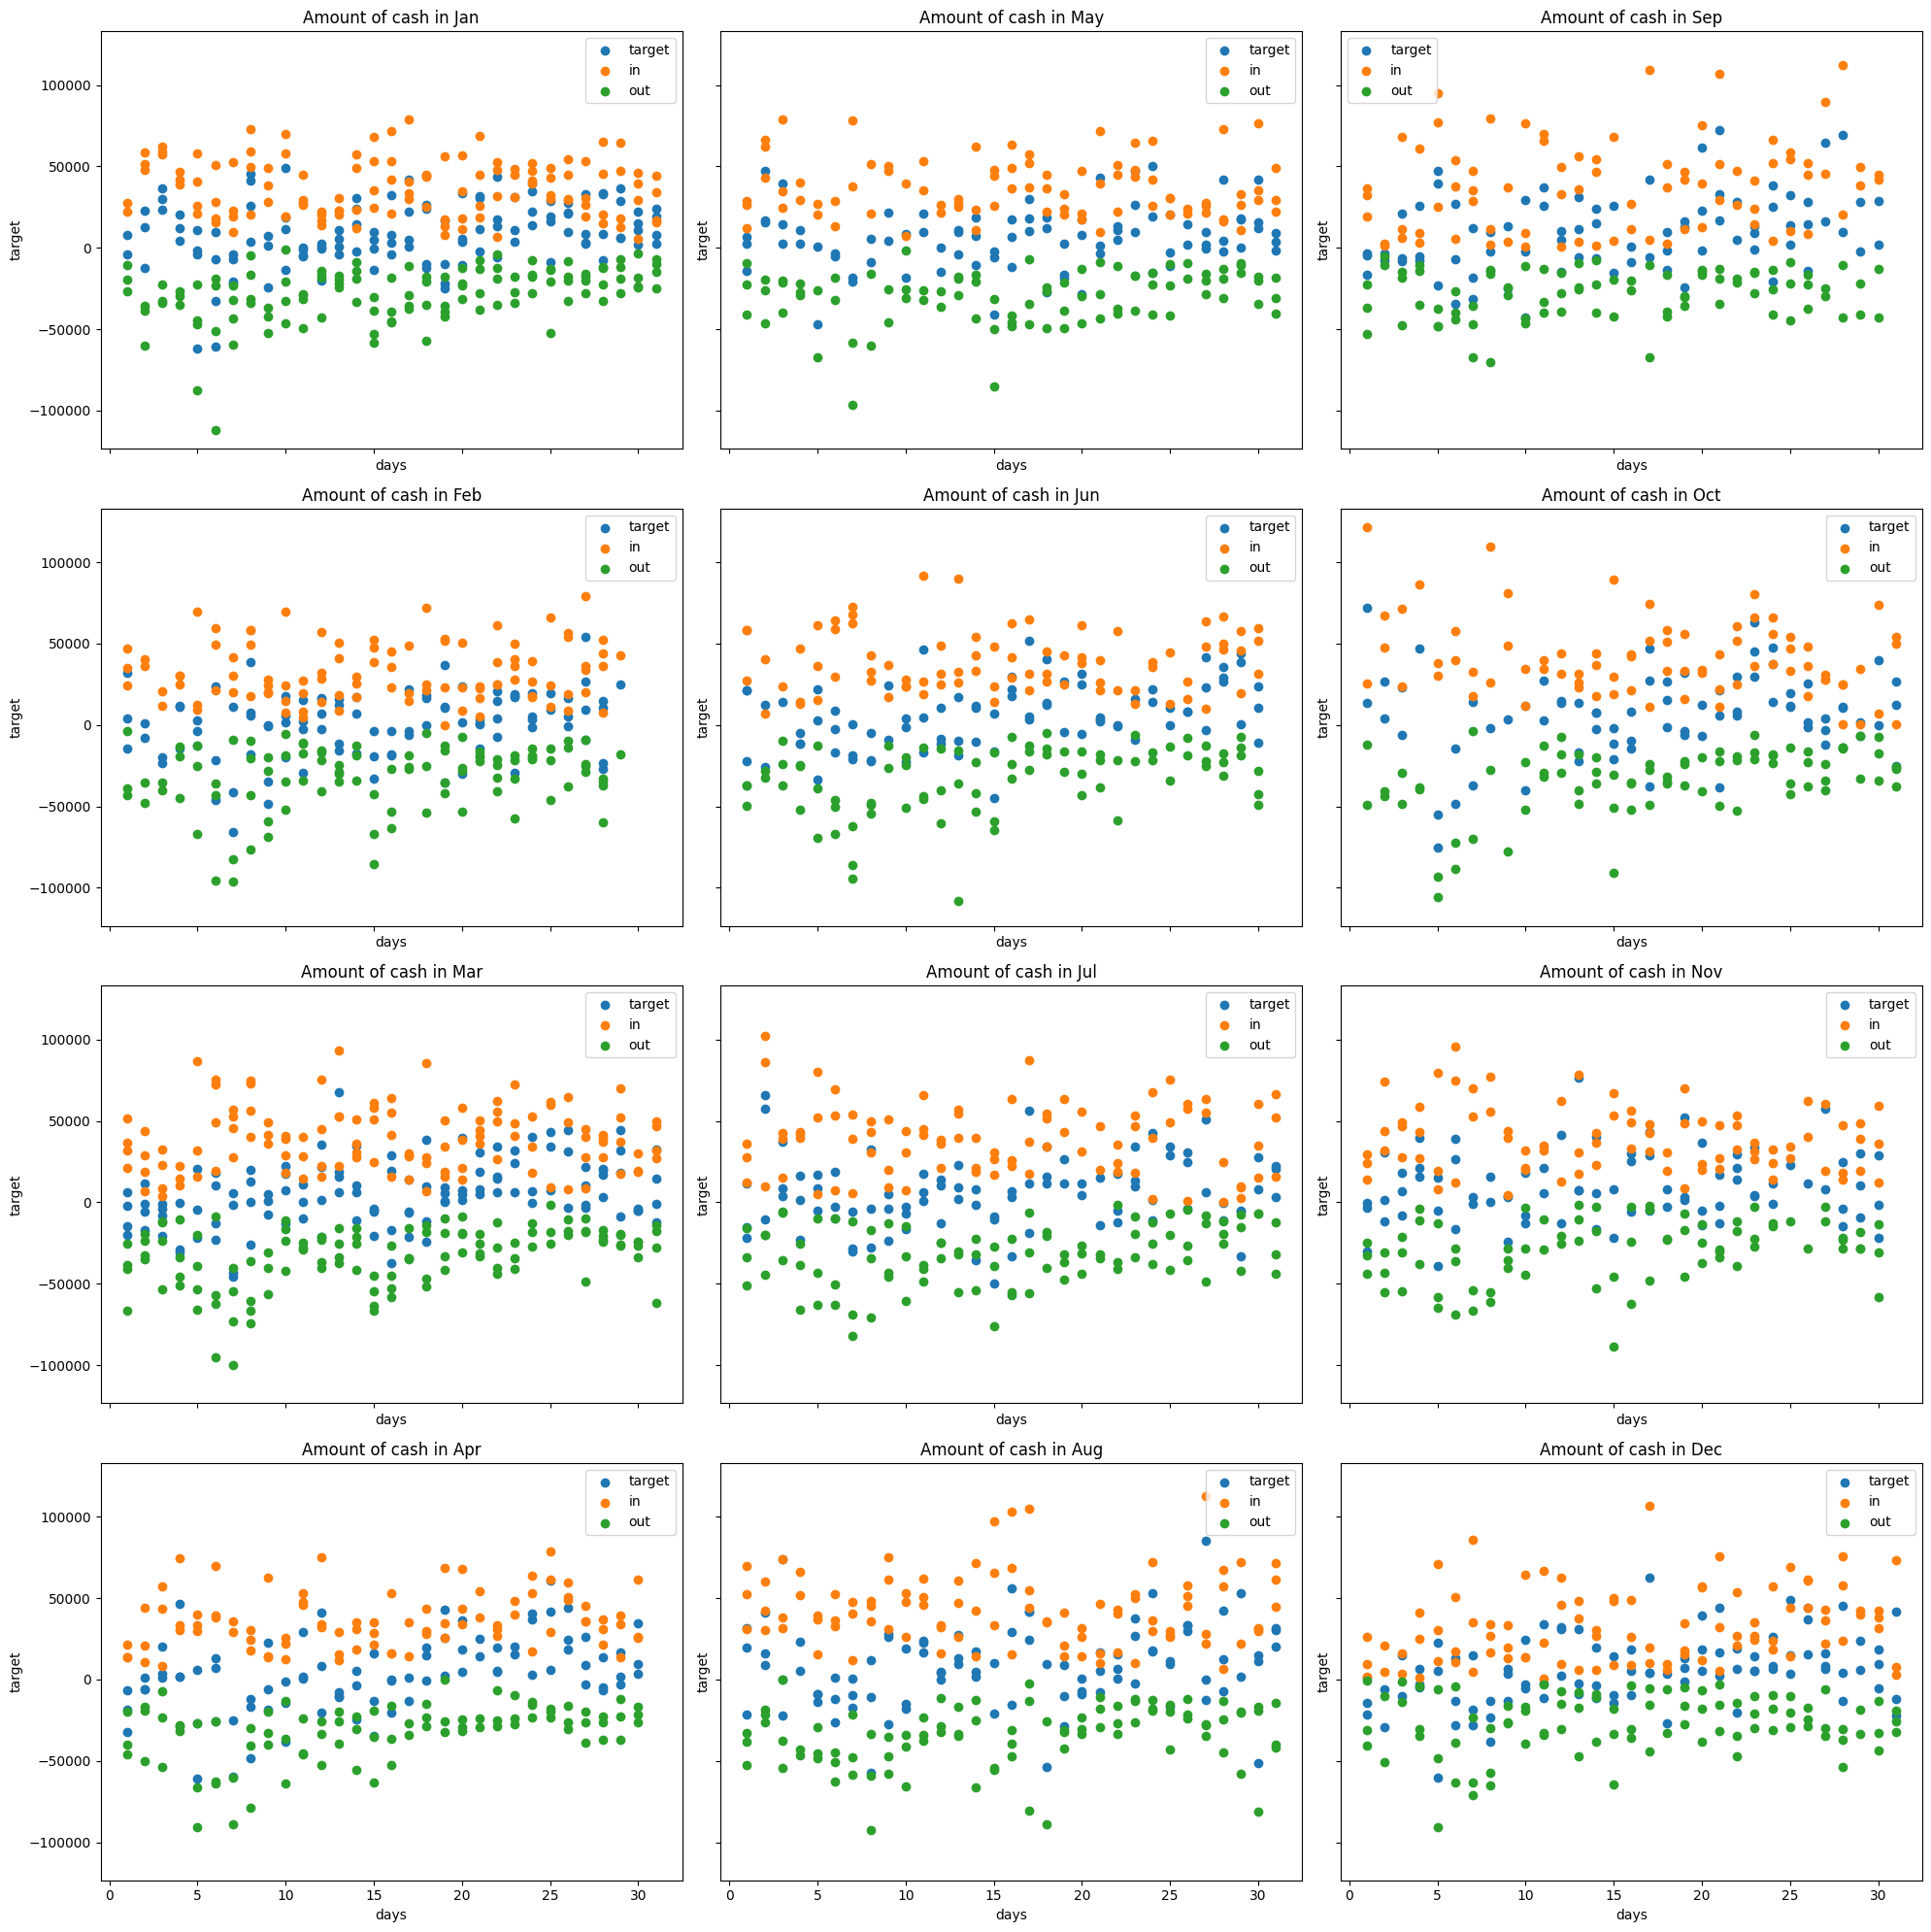

In [171]:
fig, plots = plt.subplots(4, 3, sharex=True, sharey=True, figsize=(20,20))
for month in range(12):
  month_data = df[df['Month'] == month+1]
  days = month_data['Day']
  plots[month%4, month//4].scatter(days, month_data.target, label='target')
  plots[month%4, month//4].scatter(days, month_data.CashIn, label='in')
  plots[month%4, month//4].scatter(days, month_data.CashOut, label='out')
  plots[month%4, month//4].legend()
  plots[month%4, month//4].set_ylabel('target')
  plots[month%4, month//4].set_xlabel('days')
  plots[month%4, month//4].set_title(f'Amount of cash in {calendar.month_abbr[month+1]}')
fig.tight_layout()
fig.show()

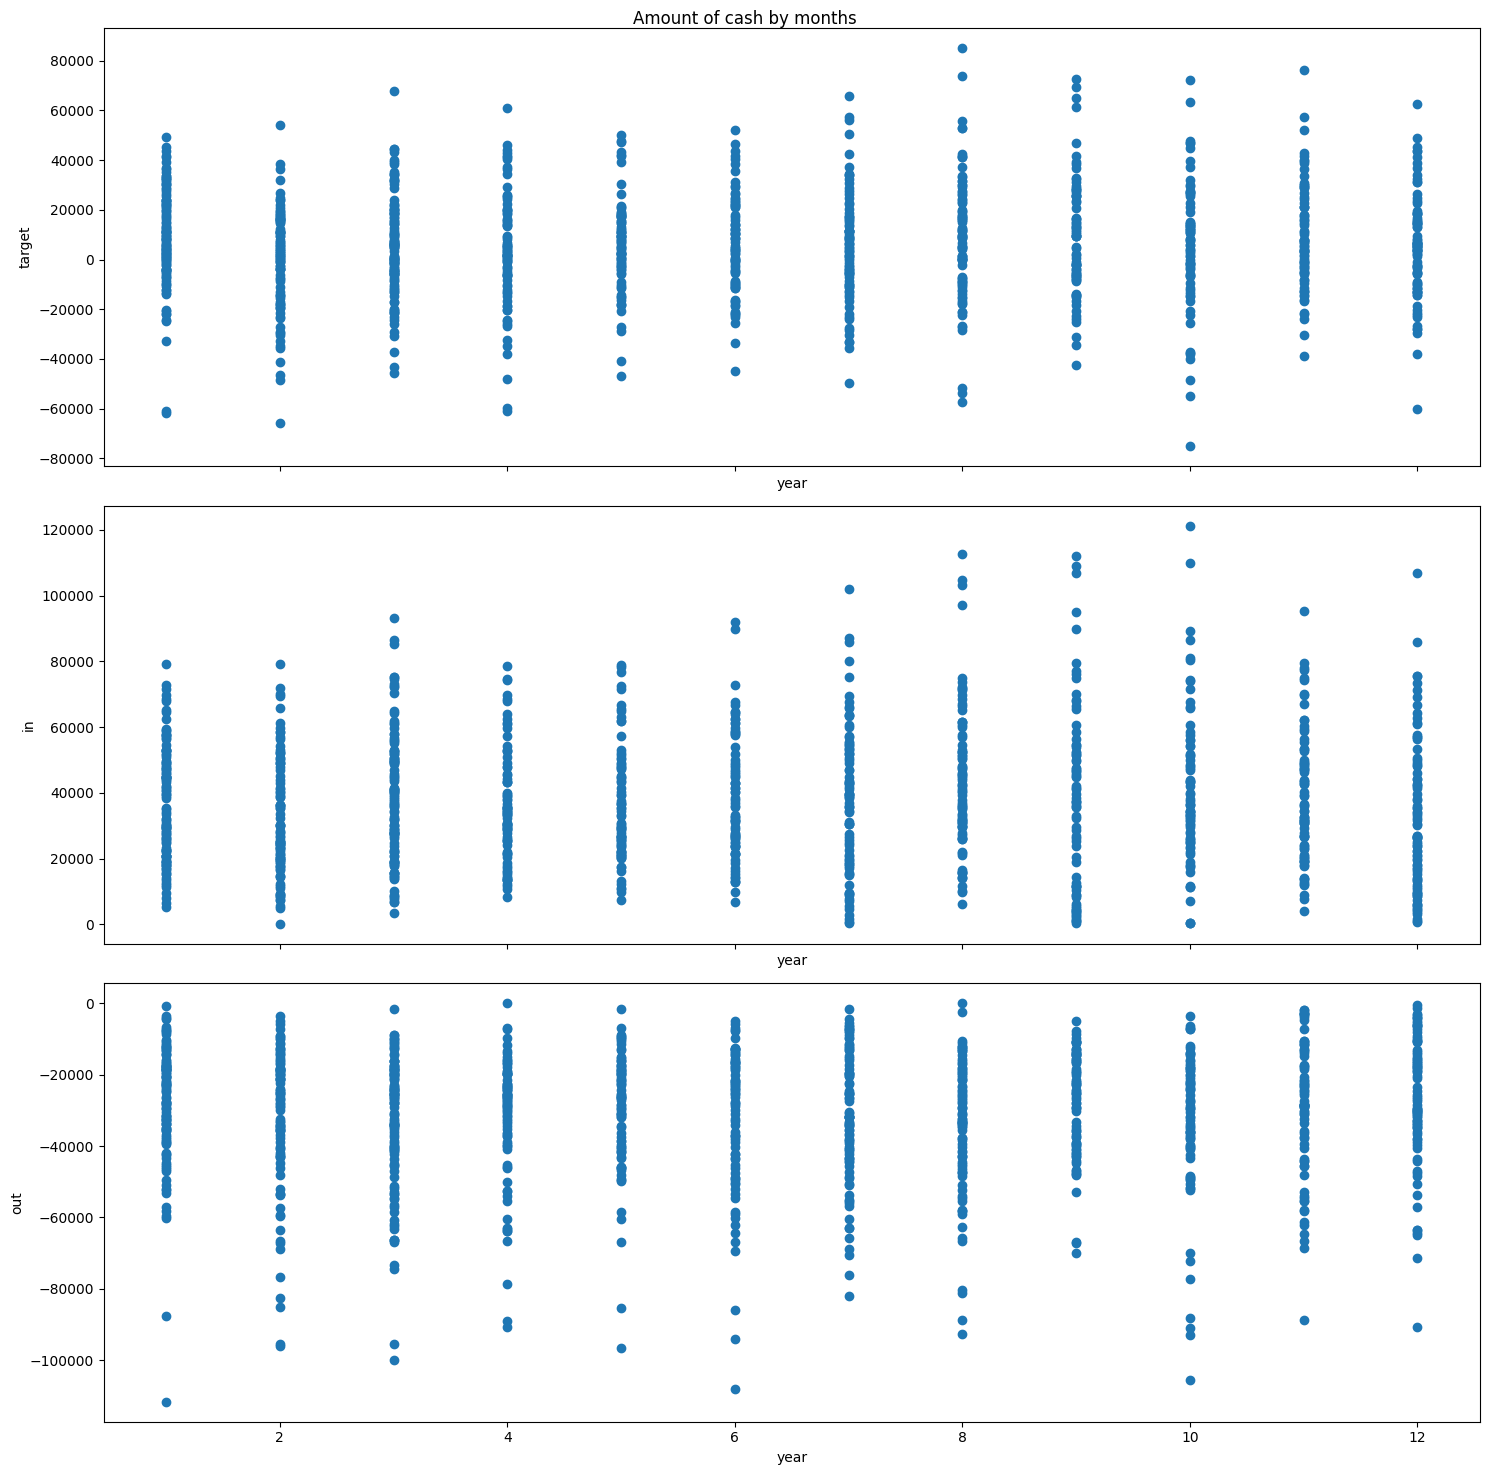

In [172]:
fig, ((ax1), (ax2), (ax3)) = plt.subplots(3, 1, sharex=True, figsize=(15,15))
ax1.scatter(df['Month'], df['target'])
ax1.set_ylabel('target')
ax1.set_xlabel('year')

ax2.scatter(df['Month'], df['CashIn'])
ax2.set_ylabel('in')
ax2.set_xlabel('year')

ax3.scatter(df['Month'], df['CashOut'])
ax3.set_ylabel('out')
ax3.set_xlabel('year')

fig.suptitle('Amount of cash by months')
fig.tight_layout()
fig.show()

Анализ распеределения по месяцам уже более информативный. Например, точно можно сказать, что в январе в банкоматах оказывается больше наличных, чем в феврале. Такая сезонность кажется оправданной (к примеру, можно ожидать, что в те месяцы, когда больше праздников, больше снимают денег, как в декабре в странах, где отмечается рождество 25 декабри или Новый год).

In [173]:
df['Weekday'] = df['Date'].apply(toweekday)

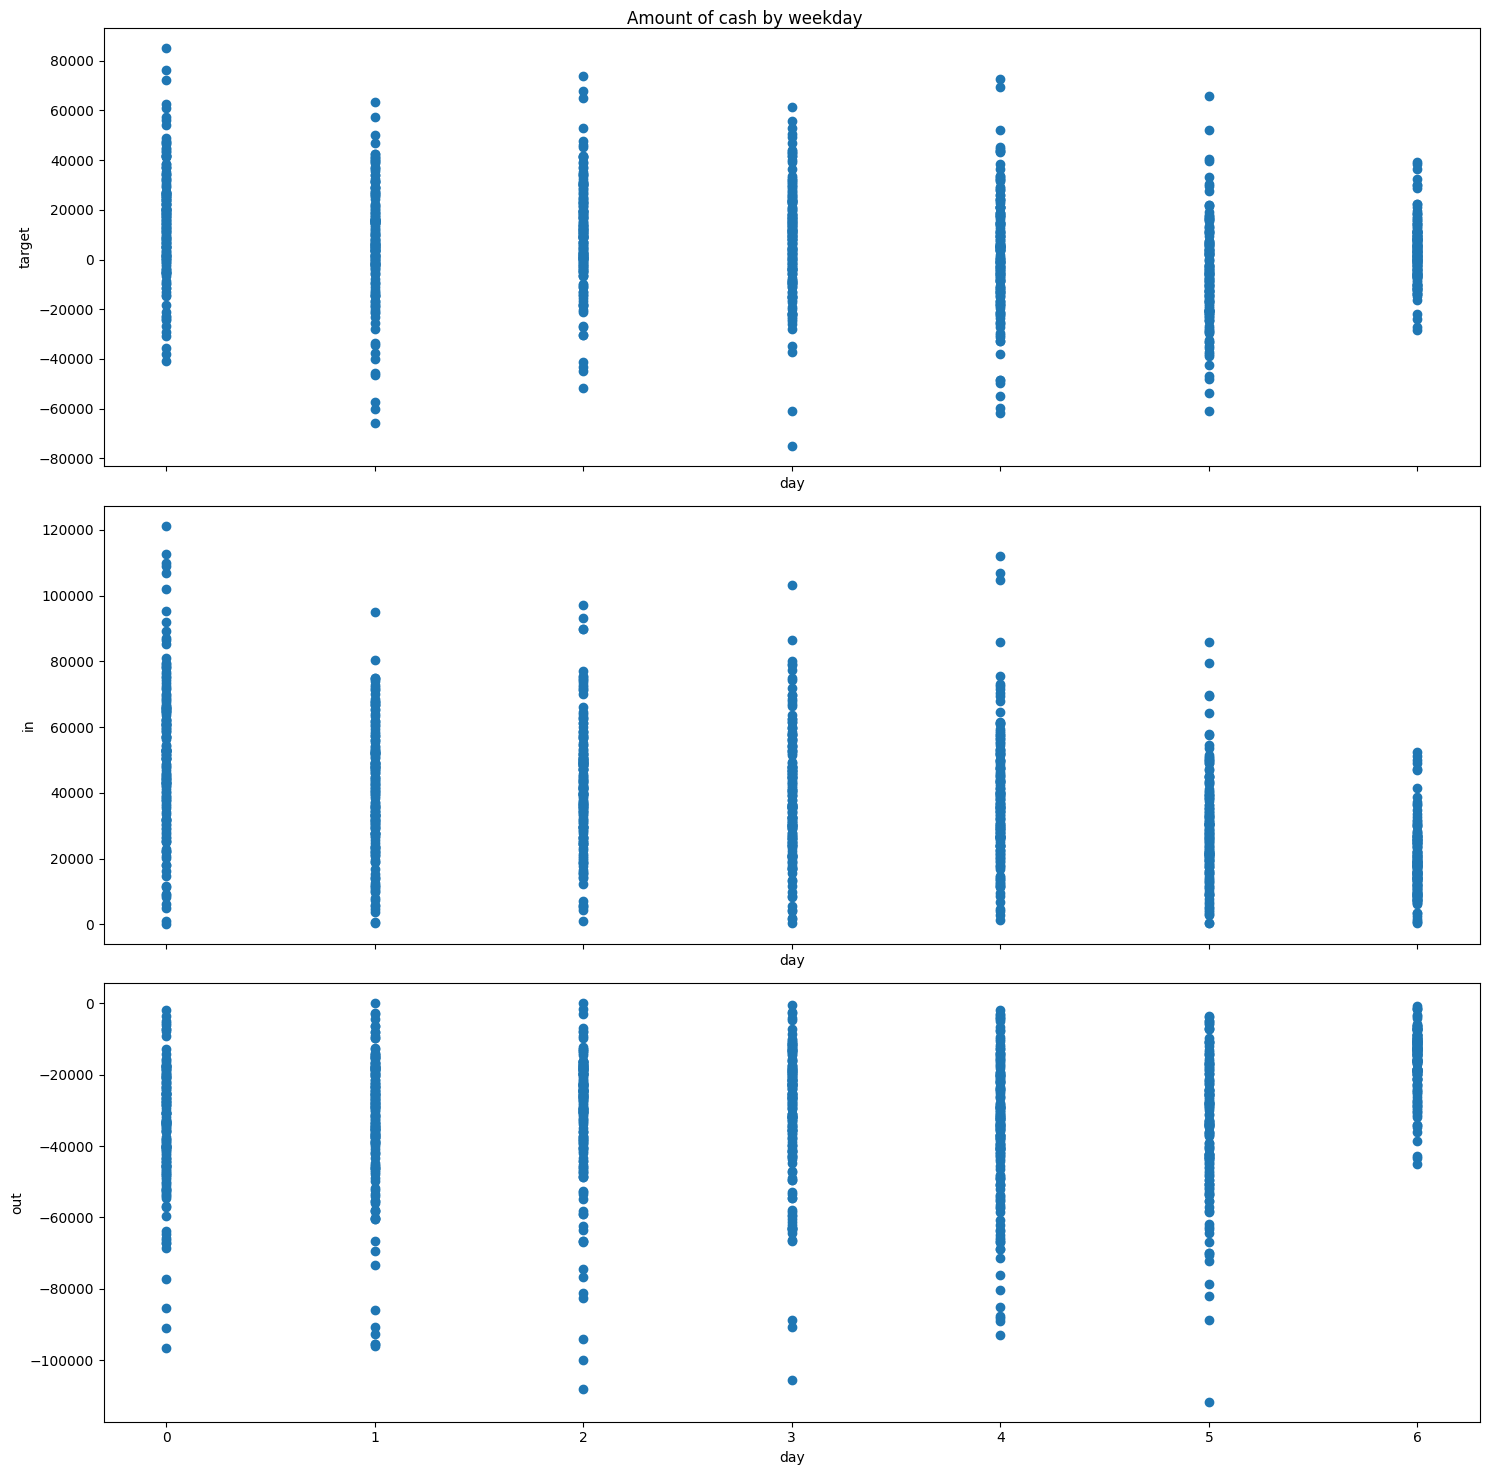

In [174]:
fig, ((ax1), (ax2), (ax3)) = plt.subplots(3, 1, sharex=True, figsize=(15,15))
ax1.scatter(df['Weekday'], df['target'])
ax1.set_ylabel('target')
ax1.set_xlabel('day')

ax2.scatter(df['Weekday'], df['CashIn'])
ax2.set_ylabel('in')
ax2.set_xlabel('day')

ax3.scatter(df['Weekday'], df['CashOut'])
ax3.set_ylabel('out')
ax3.set_xlabel('day')

fig.suptitle('Amount of cash by weekday')
fig.tight_layout()
fig.show()

Недельная сезонность также можно проследить по распределению выше. Видно, что больше всего денег снимают в субботу, а вносят -- в понедельник, что очевидно, ведь в выходные люди тратят больше.

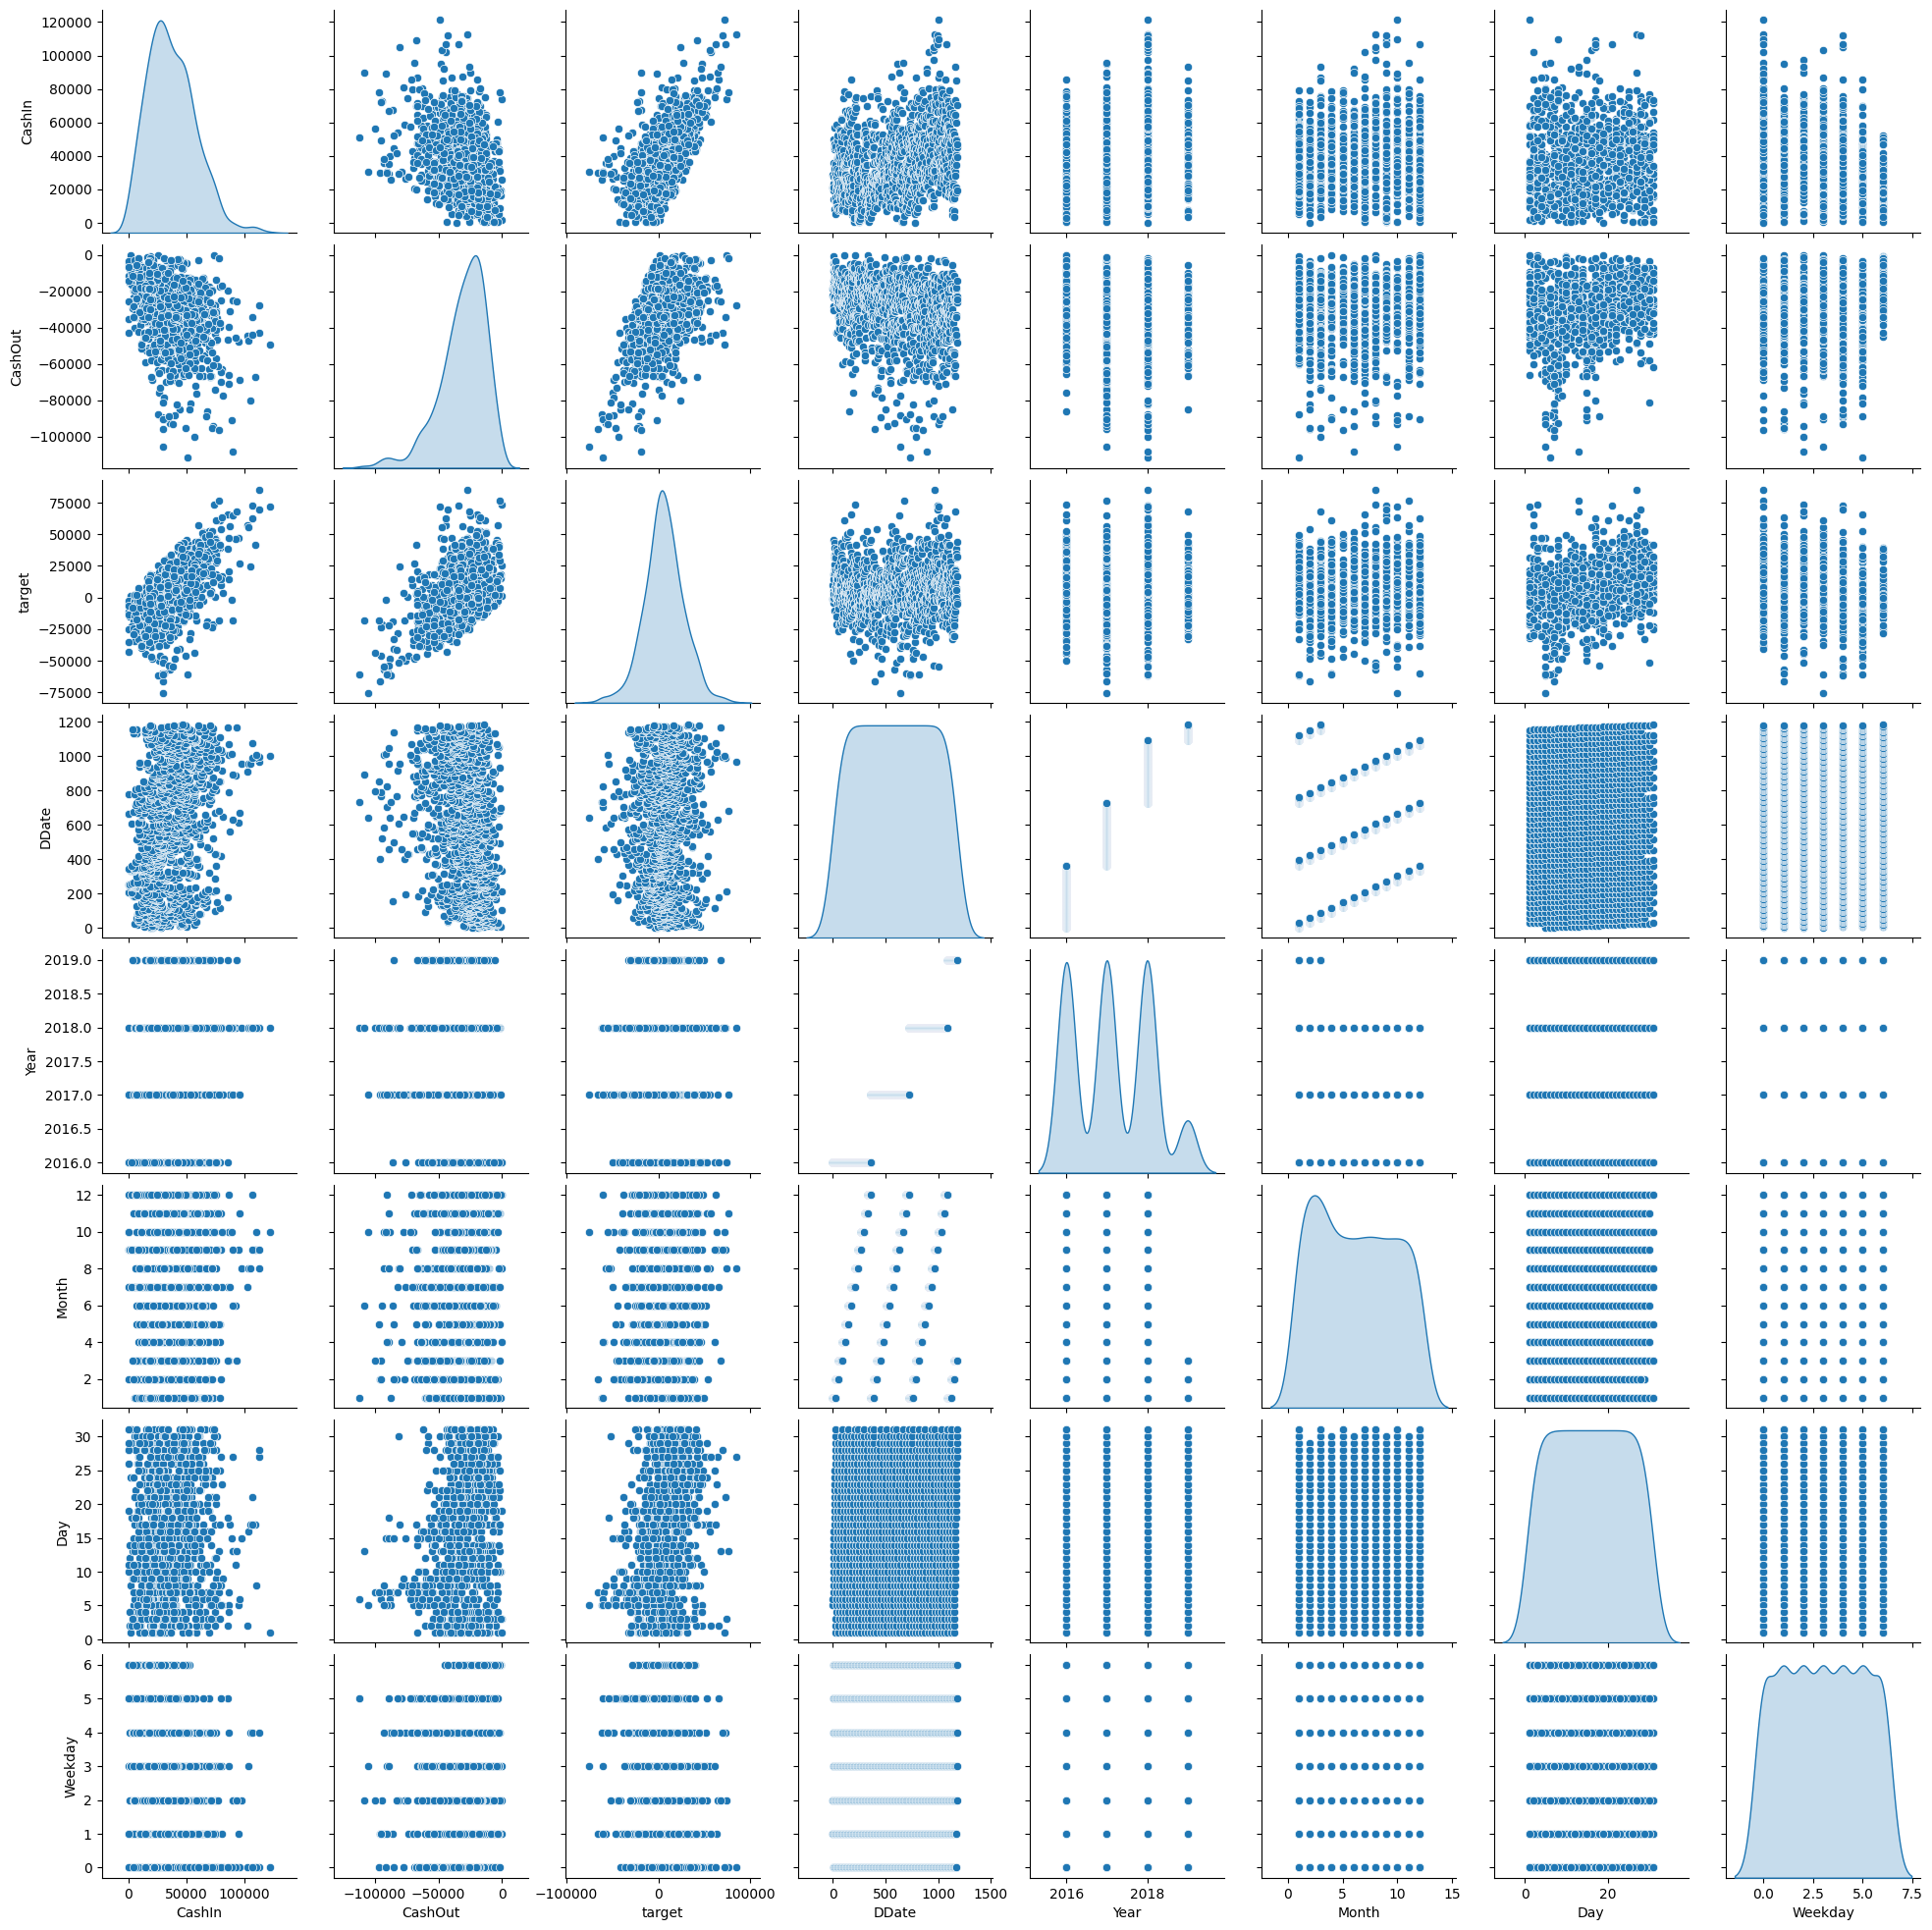

In [175]:
sns.pairplot(df, diag_kind="kde")

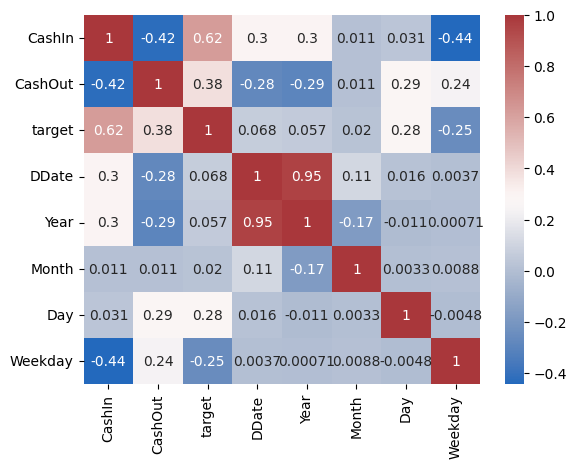

In [176]:
cmap = sns.color_palette("vlag", as_cmap=True)
sns.heatmap(df.corr("spearman"), annot=True, cmap=cmap);

Видна корреляция с днями недели, годом и датой

### Задание 2. Приведение в формат multi-segment (0.75 балла)

Теперь нам предстоит (в первый раз) привести данные к формату, в котором с ними будет возможно работать средствами ETNA. Вначале мы будем рассматривать и предсказывать наши данные как мульти-сегментные. Чтобы привести данные в соответствующий формат, вам пригодится функция `pd.melt`. На выходе у нас должен получиться объект `TSDataset`. Поскольку мы будем смотреть на данные не только в этом разрезе, лучше не менять исходный датафрейм и работать с копией.

In [177]:
from etna.datasets import TSDataset
import math

In [178]:
data = deepcopy(df)
data = pd.melt(data)

In [179]:
timestamps = data[data['variable'] == 'Date'].drop('variable', axis=1).rename(columns={'value': 'timestamp'})

In [180]:
target = deepcopy(timestamps)
target['segment'] = 'target'
target['target'] = data['value'][data['variable'] == 'target'].apply(lambda x: np.int32(x) if not math.isnan(x) else x).values
in_ = deepcopy(timestamps)
in_['segment'] = 'in'
in_['target'] = data['value'][data['variable'] == 'CashIn'].apply(lambda x: np.int32(x) if not math.isnan(x) else x).values
out_ = timestamps
out_['segment'] = 'out'
out_['target'] = data['value'][data['variable'] == 'CashOut'].apply(lambda x: np.int32(x) if not math.isnan(x) else x).values

In [181]:
to_ts = pd.concat((target, in_, out_), axis=0)

In [182]:
ts_format = TSDataset.to_dataset(to_ts)
ts = TSDataset(ts_format, freq='D')

### Задание 3. Работа с пропущенными значениями и аутлаерами (1 балл)

Проанализируйте, есть ли в данных пропущенные значения, и подберите оптимальный метод их заполнения средствами ETNA. Какие методы вы выберете и почему? Совет: возможно, лучше сохранить заполненные данные в отдельный объект, поскольку некоторые модели заполняют пропуски встроенными методами, и подача на вход "сырых" данных (на языке временных рядов это данные с нерегулярными интервалами) может принести лучший результат.

Импорты всех необходимых компонент произведите самостоятельно.

In [183]:
from etna.transforms import TimeSeriesImputerTransform

In [184]:
ts.describe()

start_timestamp end_timestamp  length  num_missing  num_segments  \
segments                                                                    
in            2016-01-05    2019-03-31    1182          101             3   
out           2016-01-05    2019-03-31    1182           88             3   
target        2016-01-05    2019-03-31    1182          110             3   

          num_exogs  num_regressors  num_known_future freq  
segments                                                    
in                0               0                 0    D  
out               0               0                 0    D  
target            0               0                 0    D

Пропущенных значения доволььно много. На мой взгляд, наиболее оправдано использование метода _running mean_, потому что таким образом мы не так сильно повлияем на нахождение тренда и не "подтасуем" данные при определении сезонности (что могло бы произойти при выборе метода _seasonal_) и, кажется, не так сильно смажем их, как могло бы быть при выборе метода _forward fill_.

In [185]:
fillna = TimeSeriesImputerTransform(strategy="running_mean", window=50)

In [186]:
ts_new = deepcopy(ts)
ts_new.fit_transform([fillna])

In [187]:
ts_new.describe()

start_timestamp end_timestamp  length  num_missing  num_segments  \
segments                                                                    
in            2016-01-05    2019-03-31    1182            0             3   
out           2016-01-05    2019-03-31    1182            0             3   
target        2016-01-05    2019-03-31    1182            0             3   

          num_exogs  num_regressors  num_known_future freq  
segments                                                    
in                0               0                 0    D  
out               0               0                 0    D  
target            0               0                 0    D

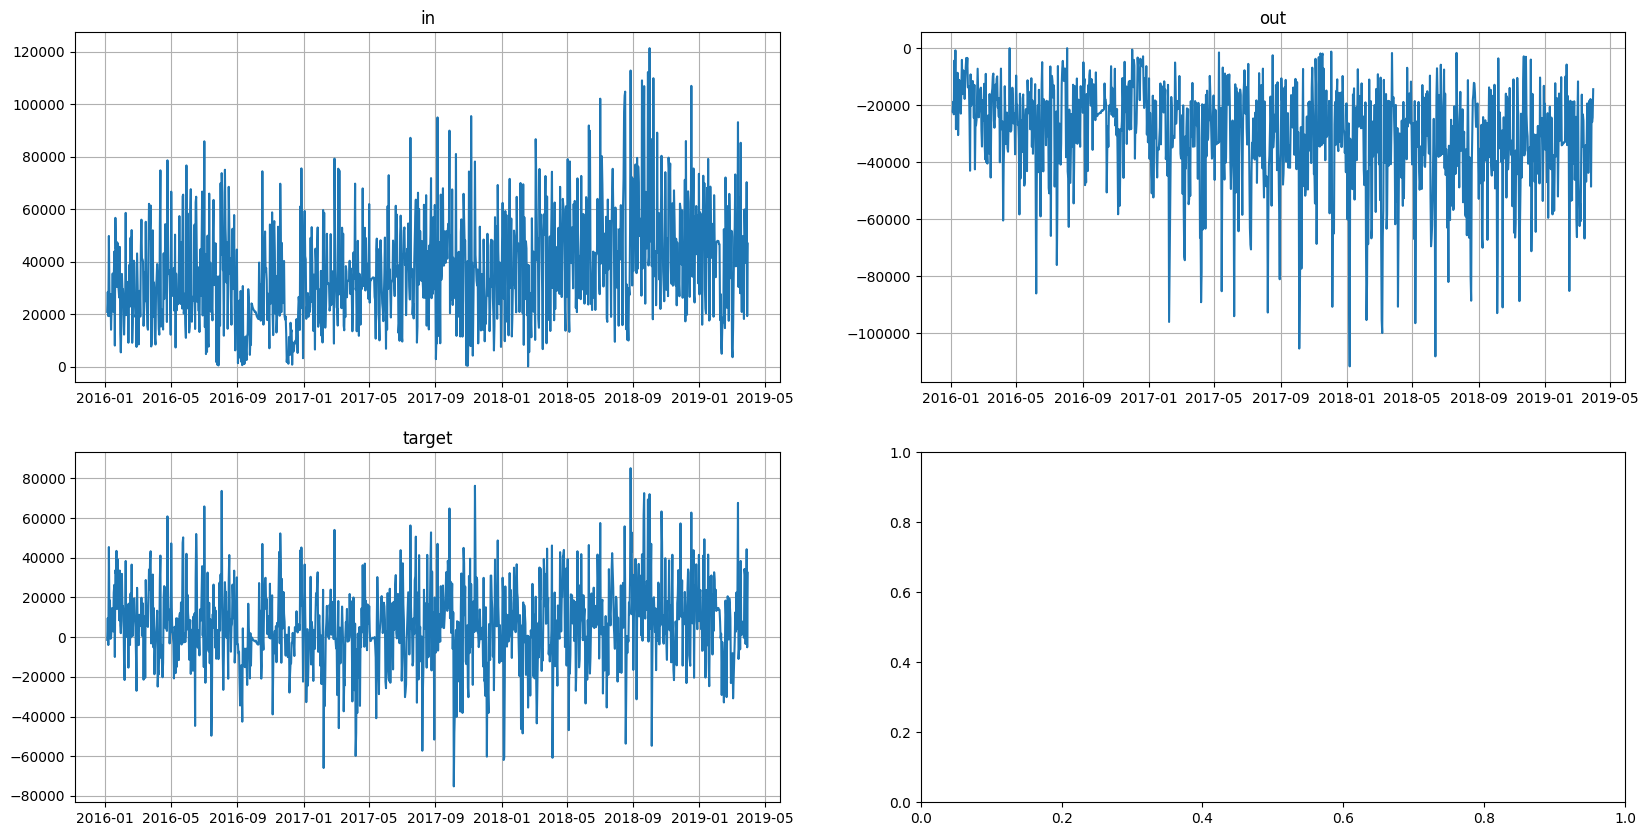

In [188]:
ts_new.plot()

В том месте, где было пропущенно много данных (~октябрь 2016), замена бросается в глаза (там образовалось неестественное плато), но я надеюсь, что сгенерированные данные перекроются настоящими

Проверьте ряды на наличие аутлаеров, и очистите их соответствующим образом. Обоснуйте выбор.

In [189]:
from etna.analysis.outliers import get_anomalies_median
from etna.analysis import plot_anomalies, plot_anomalies_interactive
from etna.transforms import MedianOutliersTransform

In [190]:
plot_anomalies_interactive(ts_new, segment='target' ,method=get_anomalies_median, params_bounds={'window_size': (10, 200, 10), 'alpha': (0.5, 7, 0.5)})

interactive(children=(IntSlider(value=10, continuous_update=False, description='window_size', max=200, min=10,…

С помощью интерактивного графика я подобрал значения, при которых аномалий не слишком много, но при этом все выбивающиеся случаи оказываются захвачены (window_size=180, alpha=2.5)

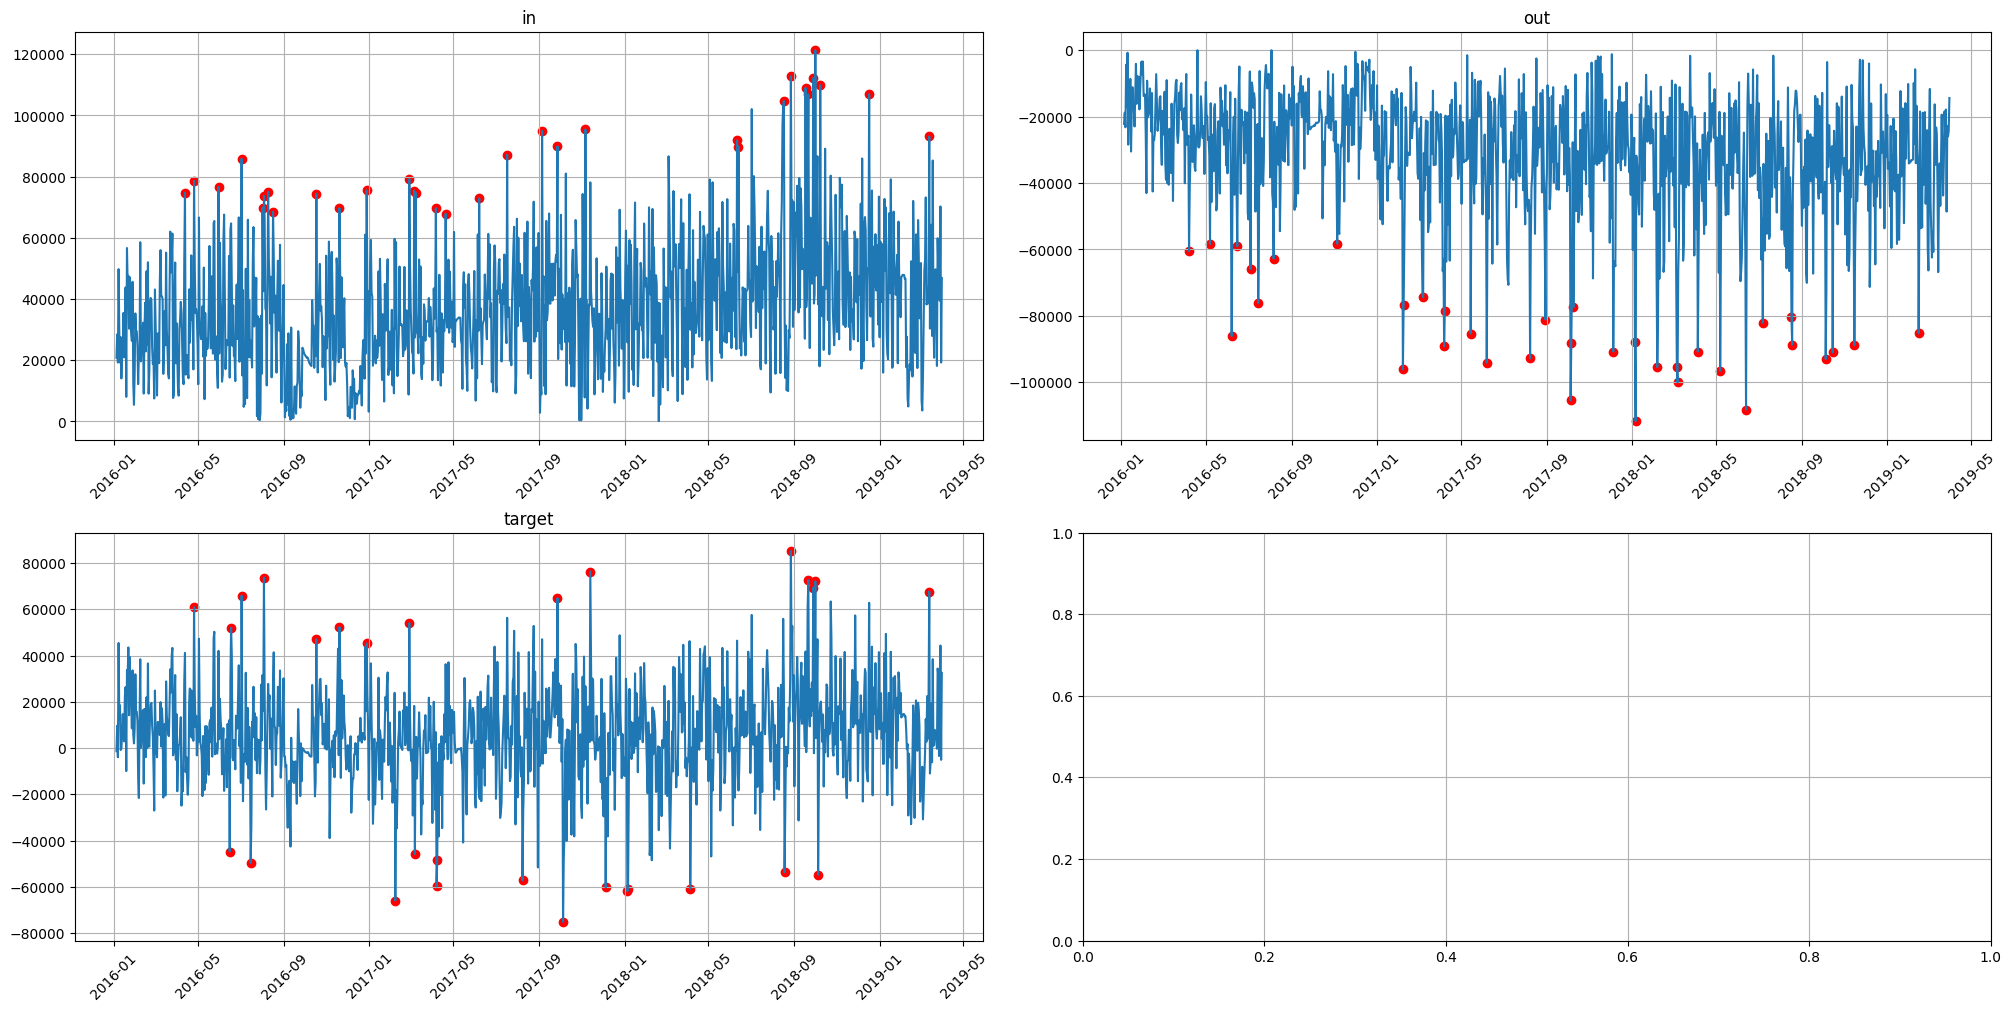

In [191]:
anomaly_dict = get_anomalies_median(ts_new, window_size=180, alpha=2.5)
plot_anomalies(ts_new, anomaly_dict)

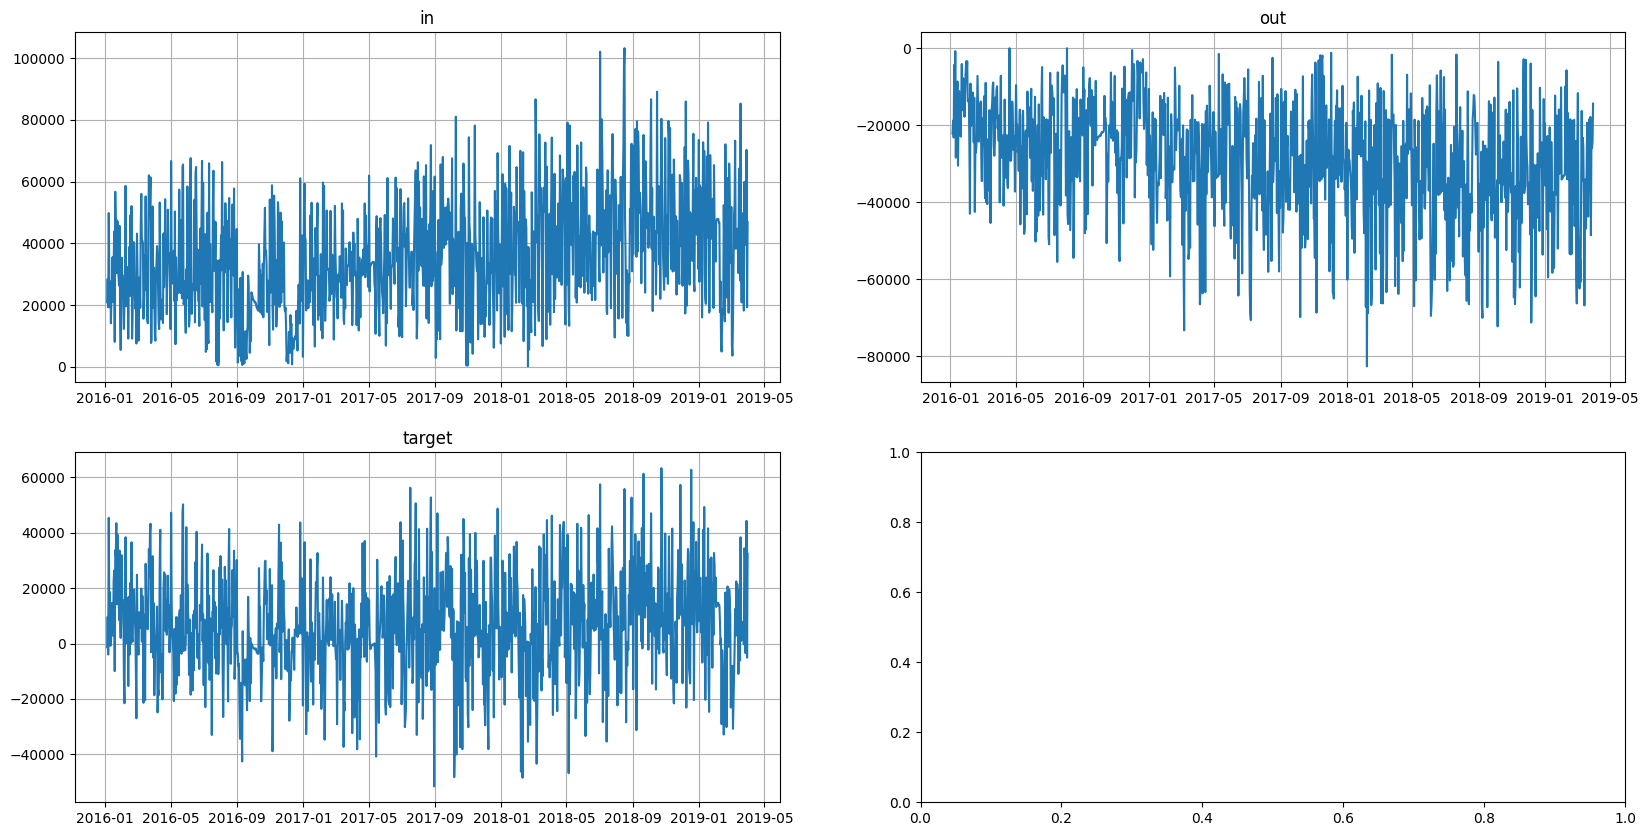

In [192]:
outliers_remover = MedianOutliersTransform(in_column="target", window_size=180, alpha=2.5)
outliers_imputer = TimeSeriesImputerTransform(in_column="target", strategy="running_mean", window=50)
ts_new.fit_transform([outliers_remover, outliers_imputer])
ts_new.plot()

### Задание 4. Построение мультисегментной модели (1.25 балла)

Постройте мульти-сегментную модель на основе Prophet, и оцените качество по SMAPE на кросс-валидации. В качестве горизонта предсказания возьмите 5 дней - этого же горизонта будем придерживаться и в дальнейшем.

Отрисуйте получившийся прогноз.

In [193]:
from etna.pipeline import Pipeline
from etna.models import ProphetModel
from etna.metrics import SMAPE, MAE
from etna.analysis import plot_backtest, plot_forecast

In [194]:
HORIZON = 5
model = ProphetModel()

In [ ]:
%%capture
pipeline = Pipeline(model=model, horizon=HORIZON)
metrics_df, forecast_df, fold_info_df = pipeline.backtest(ts=ts_new, n_folds=4, metrics=[MAE(), SMAPE()])

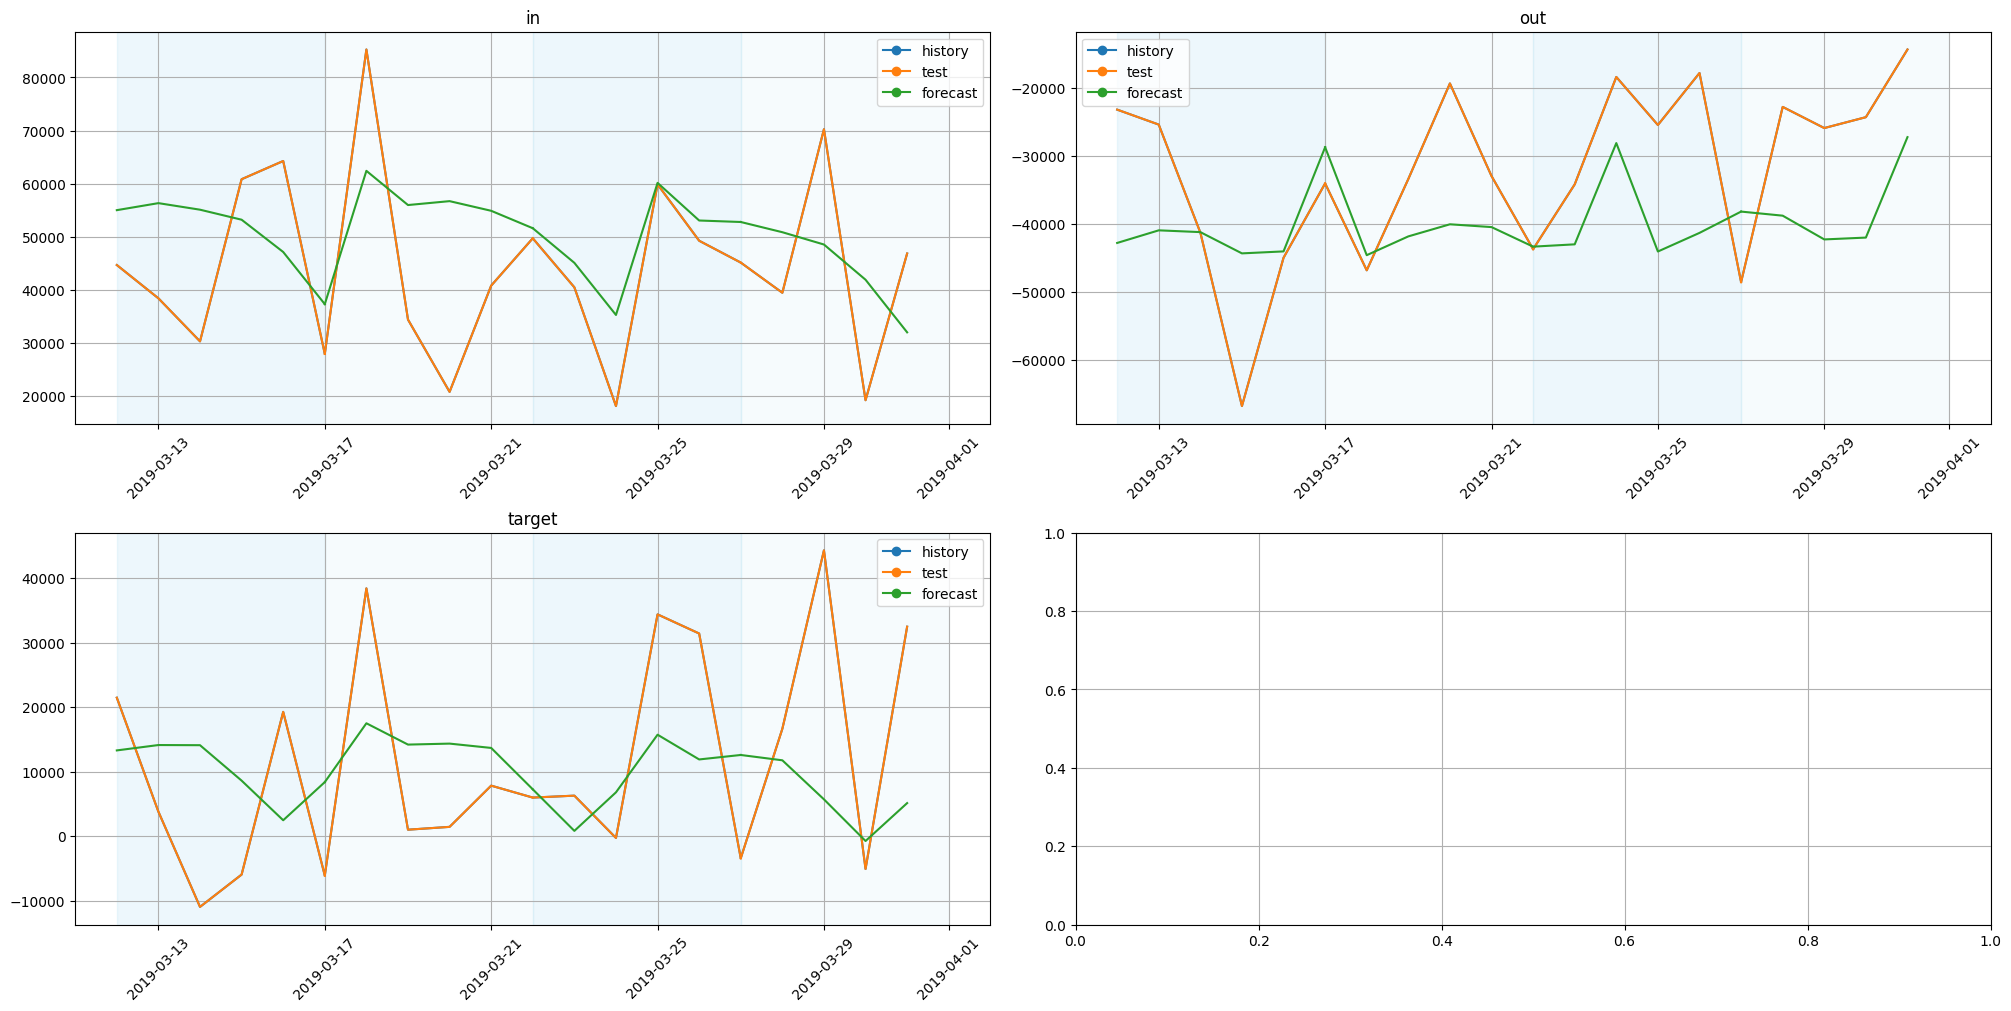

In [196]:
plot_backtest(forecast_df, ts_new)

Исходя из статистики по каждому ряду, какой можно сделать вывод о том, как лучше предсказывать итоговое значение? Посчитайте то же самое исходя из MAE.

In [197]:
metrics_df

segment           MAE       SMAPE  fold_number
2      in  15555.371419   32.126438            0
2      in  20750.925885   45.865349            1
2      in   5548.838242   17.317842            2
2      in  15652.086083   37.824139            3
1     out  11718.692470   29.752148            0
1     out   8839.799944   26.850018            1
1     out  12201.880346   39.640281            2
1     out  14663.732708   47.768046            3
0  target  14991.870755  143.466998            0
0  target  13472.603032  133.382732            1
0  target  10401.061606  107.699669            2
0  target  18242.319500  136.480214            3

На первый взгляд кажется, что суммарная ощибка по in и out меньше, чем по target. Попробую пересчитать статистики для отдельных фолдов

In [198]:
def mae(actual, pred):
  return sum(abs(actual - pred)) / actual.shape[0]

def smape(actual, pred):
  return sum(abs(actual - pred) / ((abs(actual) + abs(pred)) / 2)) * 100 / actual.shape[0]

def get_fold_stat(actual, forecast, fold_num, fold_info=fold_info_df):
  start = fold_info_df[fold_info_df['fold_number'] == fold_num]['test_start_time'].values[0]
  end = fold_info_df[fold_info_df['fold_number'] == fold_num]['test_end_time'].values[0]
  A = actual[start:end]['target'].values[:, 0]
  F_comb = (forecast[start:end]['in'] + forecast[start:end]['out']).values[:, 1]
  F_tar = forecast['2019-03-27':]['target'].values[:, 1]

  return pd.DataFrame([[mae(A, F_comb), smape(A, F_comb)], [mae(A, F_tar), smape(A, F_tar)]], index=['in+out', 'target'], columns=['MAE', 'SMAPE'])

In [199]:
[get_fold_stat(ts_new, forecast_df, i, fold_info_df) for i in range(4)]

[                 MAE       SMAPE
 in+out  15343.500252  144.229492
 target  10576.379839  125.114032,
                  MAE       SMAPE
 in+out  14040.775321  134.937876
 target  10991.962001  137.779210,
                  MAE       SMAPE
 in+out  10384.099001   99.378152
 target  15902.226191  135.210343,
                  MAE       SMAPE
 in+out  18677.142664  144.498995
 target  18242.319500  136.480214]

Видно, что например на третьем (2) фолде сложение стобцов in и out оказывается значительно эффескивнее. Поэтому вероятно у такого подхода есть потенциал

### Задание 5. Иерархический временной ряд (2 балла)

Вопрос, поставленный в прошлом задании, тем не менее, естественным образом подводит нас к концепции **иерархического временного ряда** (когда один ряд состоит из других в качестве компонент). Это полезная концепция, которая может встретиться во многих задачах. В этом задании вам предстоит самостоятельно разобраться в деталях ее реализации в ETNA с использованием справочных материалов, предоставляемых библиотекой (как это часто бывает на практике). Они содержатся по следующей ссылке:

https://github.com/tinkoff-ai/etna/blob/master/examples/hierarchical_pipeline.ipynb

На выходе из первой части задания необходимо получить `TSDataset` с иерархической структурой, а также соответствующий реконсилятор, который позволит собирать искомый ряд из составных компонент. Классы, которые вам понадобятся, импортированы ниже.

In [200]:
from etna.datasets import HierarchicalStructure
from etna.pipeline import HierarchicalPipeline
from etna.reconciliation import BottomUpReconciliator

In [201]:
hierarchical_structure = HierarchicalStructure(level_structure={"total": ["in", "out"]}, level_names=["total", "input"])
hierarchical_ts = TSDataset(df=ts_format[['in', 'out']], freq="D", hierarchical_structure=hierarchical_structure)
reconciliator = BottomUpReconciliator(target_level="total", source_level="input")

Во второй части задания примените найденные на предыдущих этапах преобразования очистку от аутлаеров уже к иерархическому датасету, и запустите на нем Prophet с MASE и MAE на кросс-валидации.

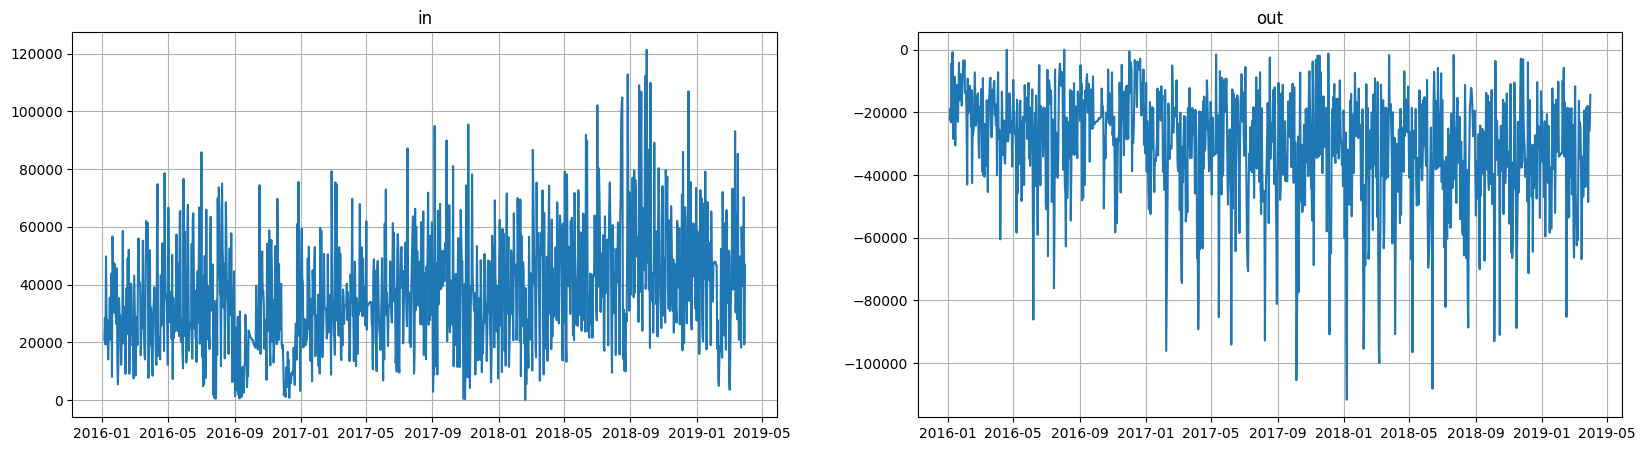

In [202]:
outliers_remover = MedianOutliersTransform(in_column="target", window_size=180, alpha=2.5)
outliers_imputer = TimeSeriesImputerTransform(in_column="target", strategy="running_mean", window=50)
hierarchical_ts.fit_transform([outliers_remover, outliers_imputer])
hierarchical_ts.plot()

In [203]:
hierarchical_ts.describe()

start_timestamp end_timestamp  length  num_missing  num_segments  \
segments                                                                    
in            2016-01-05    2019-03-31    1182            0             2   
out           2016-01-05    2019-03-31    1182            0             2   

          num_exogs  num_regressors  num_known_future freq  
segments                                                    
in                0               0                 0    D  
out               0               0                 0    D

In [ ]:
%%capture
reconciliator = reconciliator.fit(ts=hierarchical_ts)
pipeline = HierarchicalPipeline(model=model, reconciliator=reconciliator)
metrics_df, forecast_df, fold_info_df = pipeline.backtest(ts=hierarchical_ts, n_folds=10,  metrics=[MAE(), SMAPE()])

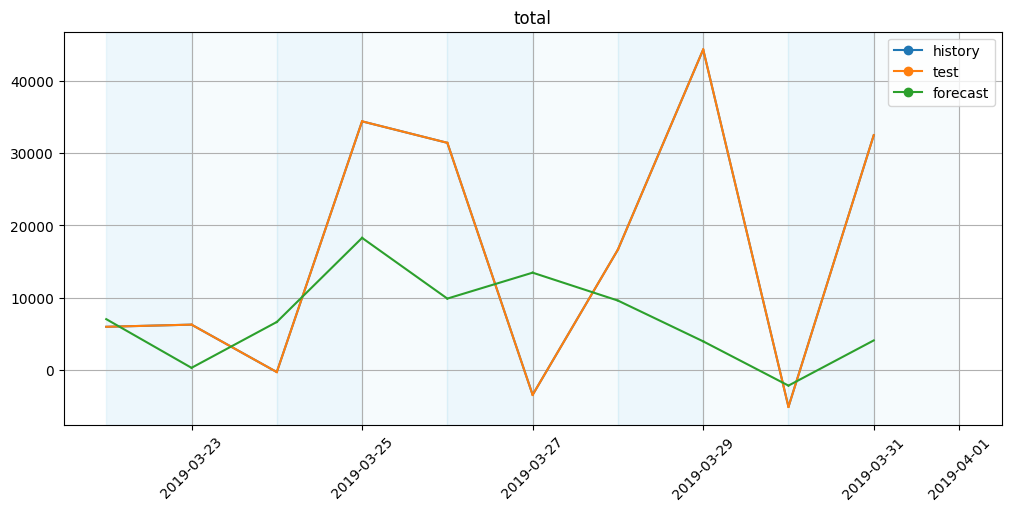

In [243]:
plot_backtest(forecast_df, reconciliator.reconcile(hierarchical_ts))

In [244]:
metrics_df

segment           MAE       SMAPE  fold_number
0   total   1059.038438   16.294104            0
0   total   5972.367694  181.872779            1
0   total   6925.566846  200.000000            2
0   total  16114.675327   61.219778            3
0   total  21538.749941  104.351249            4
0   total  16895.671021  200.000000            5
0   total   7042.170349   53.679519            6
0   total  40353.296708  167.209666            7
0   total   2939.293234   80.964383            8
0   total  28382.335139  155.274333            9

### Задание 6. Построение признаков (1.5 балла)

Вернемся к нашему исходному мультисегментному ряду - теперь поработаем с моделями, которые требуют построения признаков - `ARIMA` и `CatBoost`. Построим для них признаки, и попробуем при помощи них добиться улучшения качества. Из обязательного: 1) постройте графики автокорреляции и при помощи них обоснуйте выбор лаговых признаков 2) для катбуста включите в признаки результаты STL разложения. Кроме этого, подумайте на экспертном уровне, какие закономерности могут присутствовать в пополнени наличности из банкомата? Снятии? Что из этого кажется более предсказуемым, и почему? Cделайте соответствующие признаки, и снабдите их кратким комментарием.

После этого, обучите на получившихся признаках модели.

Ниже приведены импорты, которые вам точно понадобятся - к ним необходимо добавить те инструменты, которые вы дополнительно решите использовать в анализе.

In [207]:
from etna.analysis import sample_acf_plot, sample_pacf_plot, stl_plot
from etna.ensembles import DirectEnsemble, StackingEnsemble, VotingEnsemble
from etna.models import (CatBoostMultiSegmentModel, CatBoostModelPerSegment,
                         AutoARIMAModel)
from etna.transforms import STLTransform, LagTransform, SegmentEncoderTransform
import requests
from bs4 import BeautifulSoup

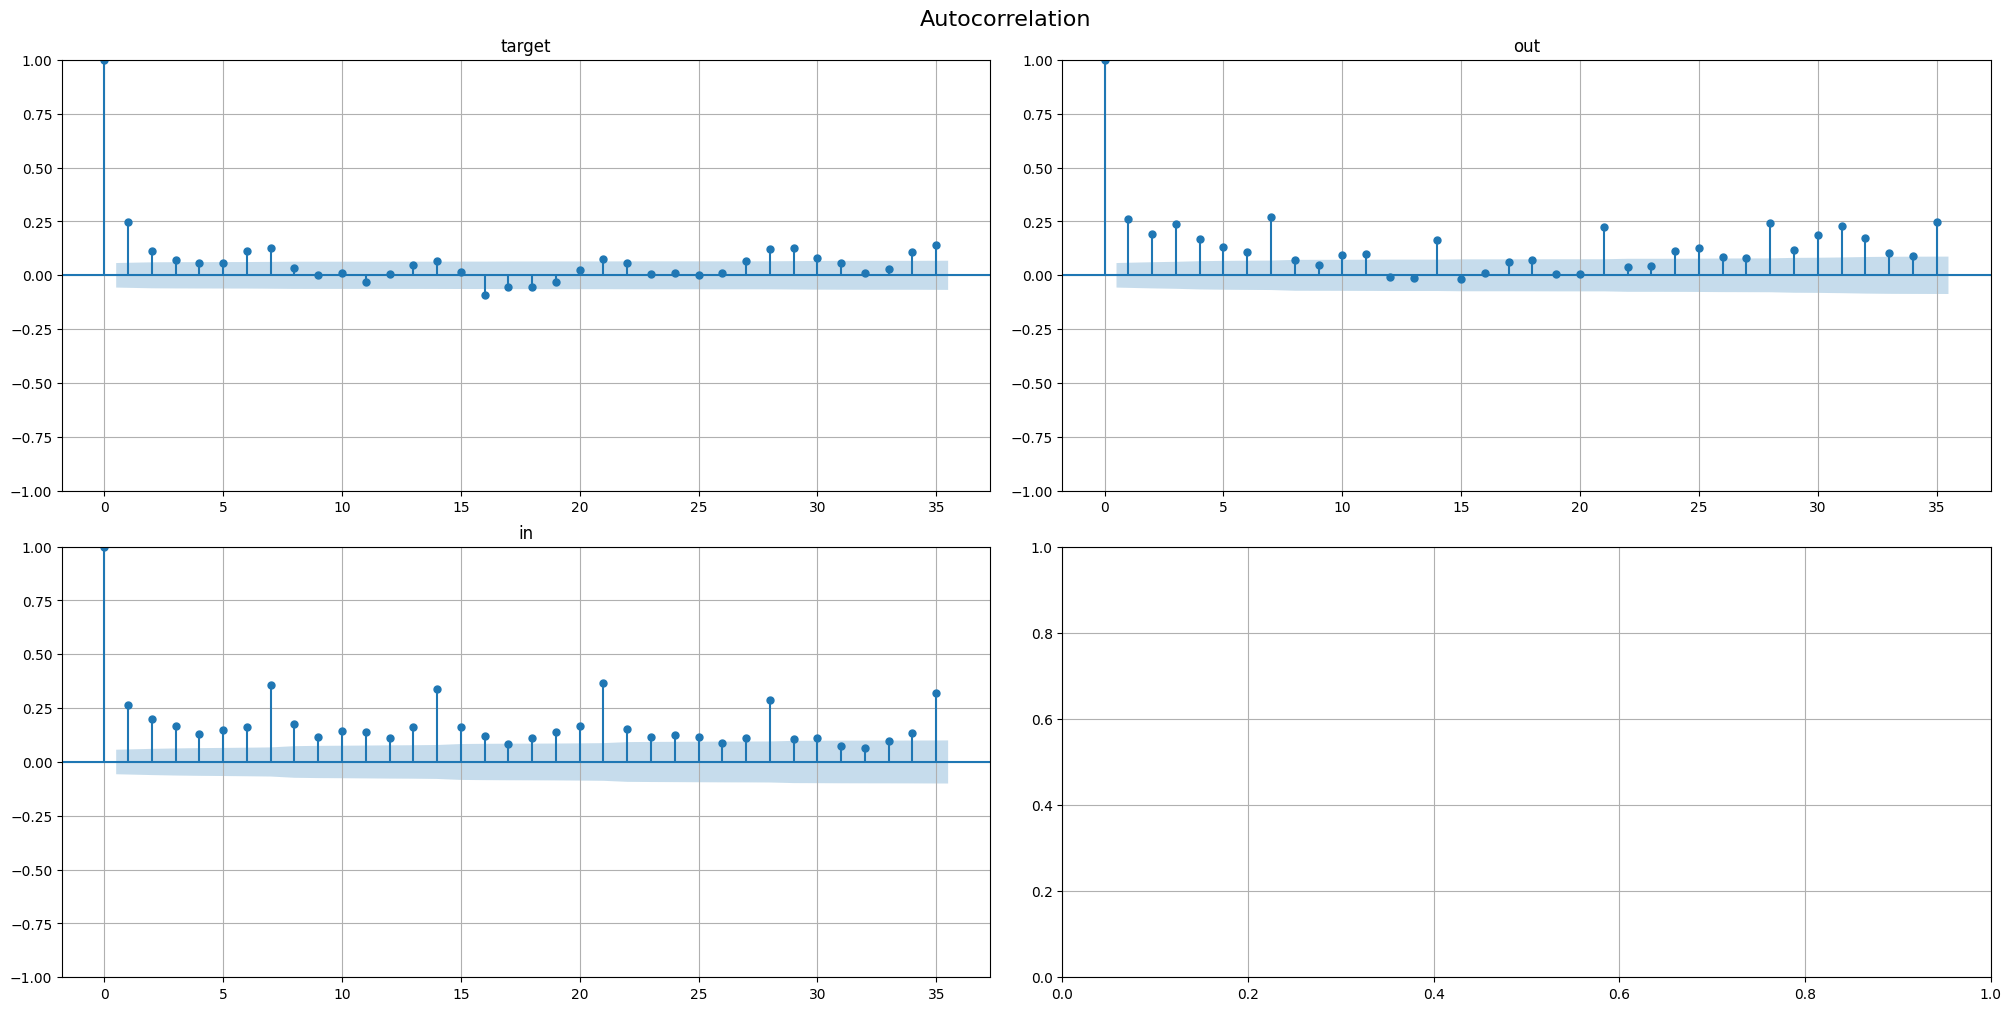

In [208]:
sample_acf_plot(ts_new, lags=35)

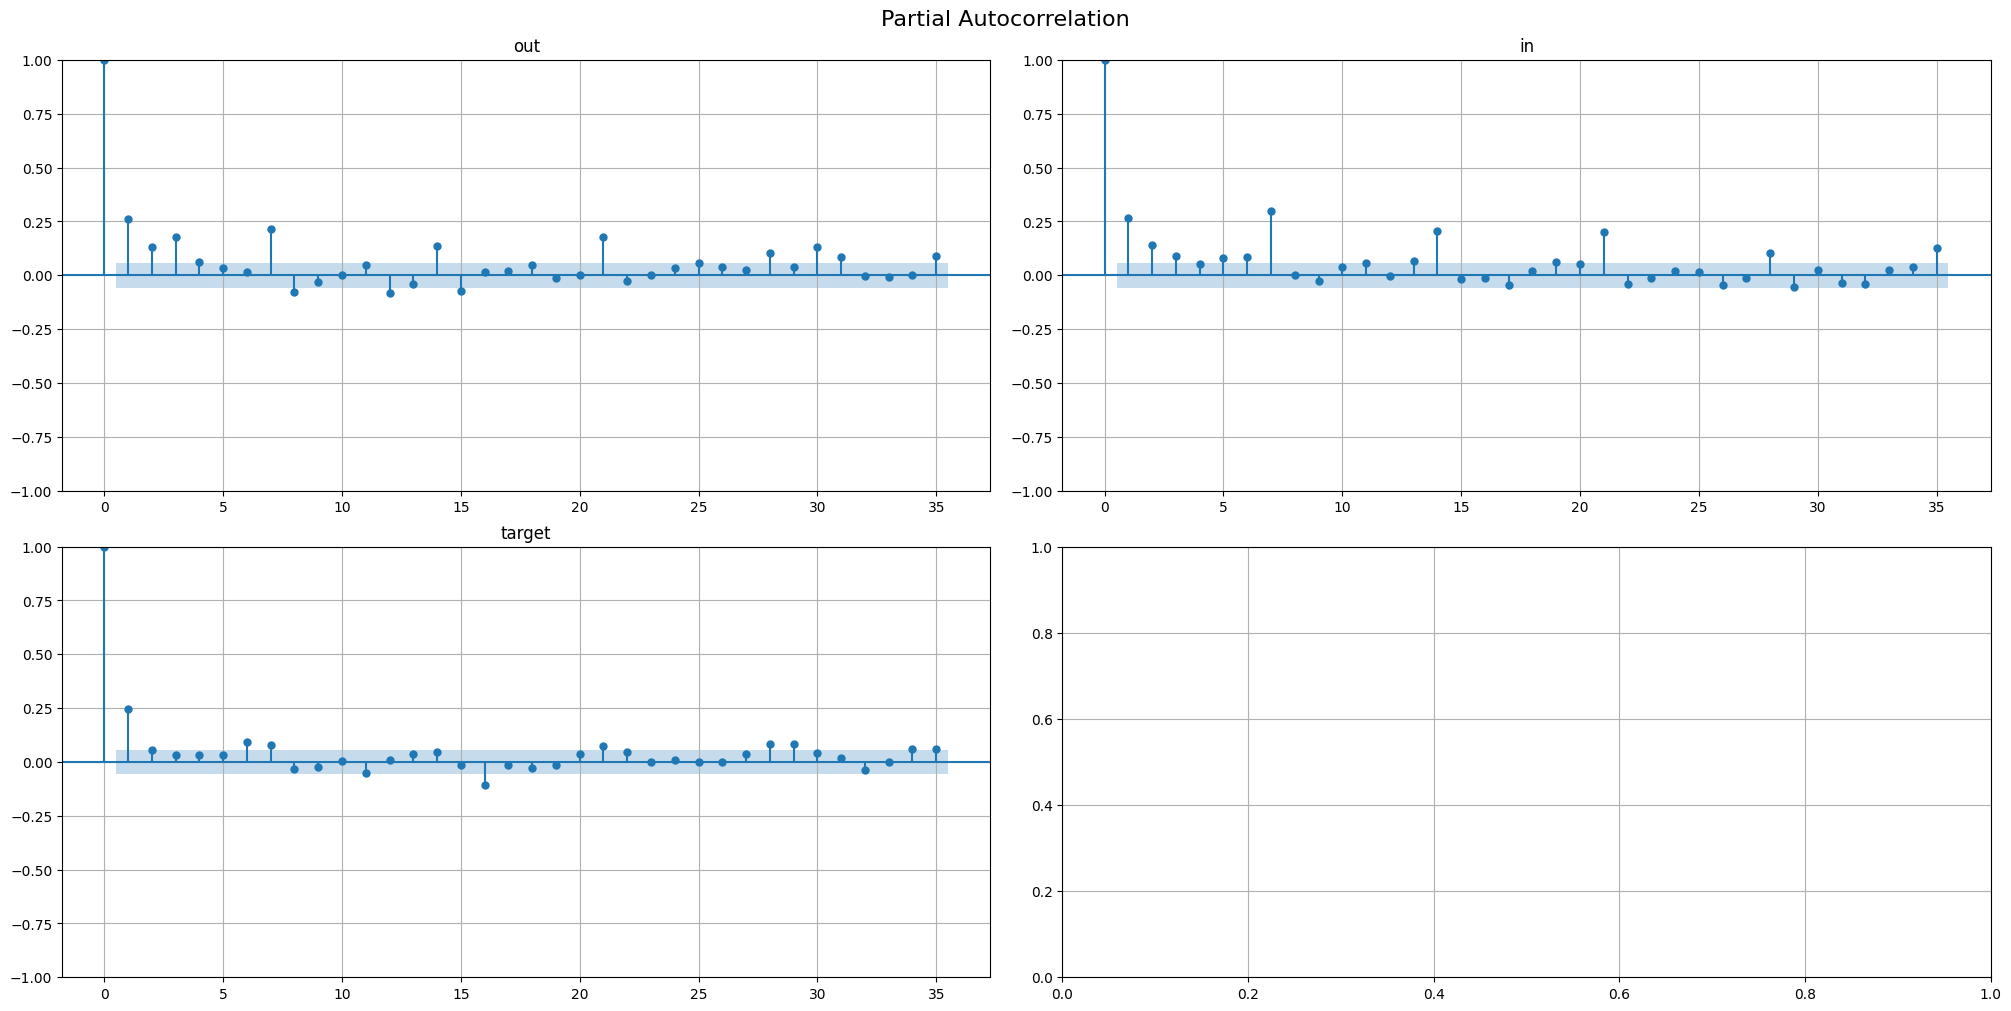

In [209]:
sample_pacf_plot(ts_new, lags=35)

На графиках видно, что наиболее обоснованный выбор лага -- это 7 дней, что довольно логично. Это особенно заметно на графике внесения денег в аппарат, где выделяются значения, кратные 7, на графике снятия денег это также прослеживается

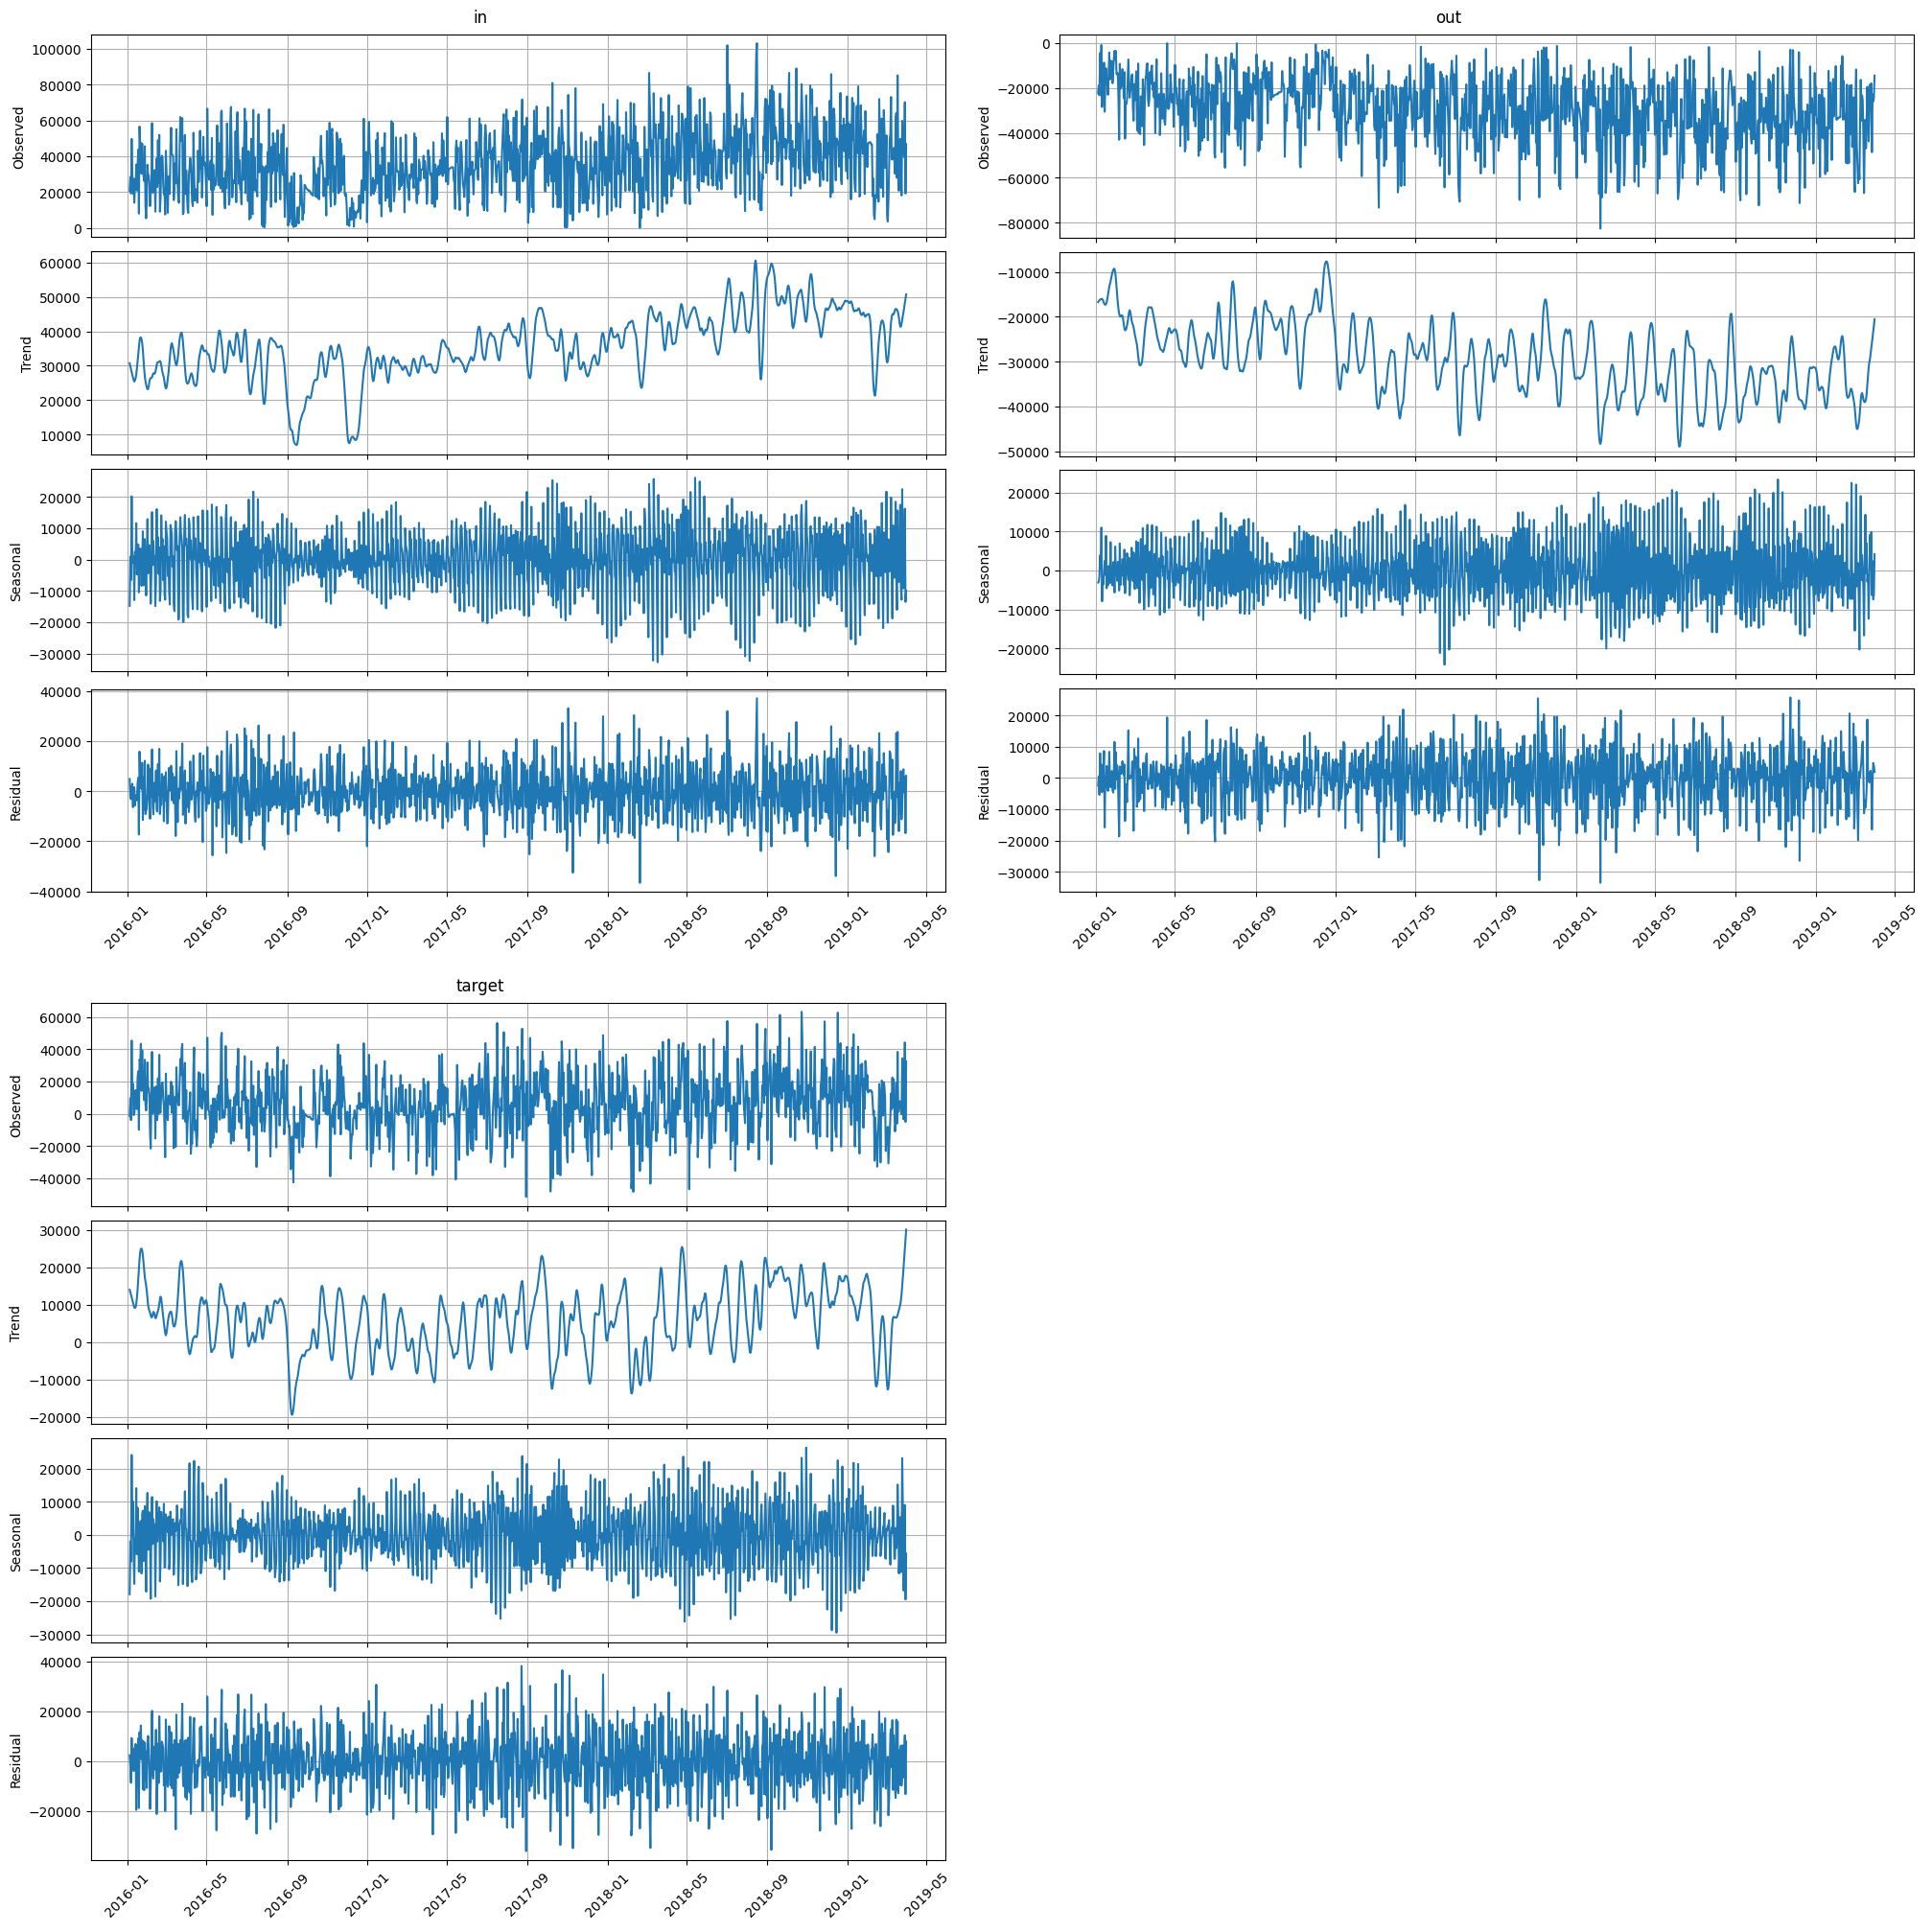

In [210]:
stl_plot(ts_new, period=7)

Как я писал раньше, на снятие/внесение денег в банкомат могут влиять праздничные дни. Поэтому я решил их напарсить с сайта https://www.officeholidays.com/countries/turkey/

In [211]:
holidays = []
for year in range(2016, 2020):
  url = 'https://www.officeholidays.com/countries/turkey/' + str(year)
  page = requests.get(url)
  parser = BeautifulSoup(page.text)
  dates = parser.find_all('table', {'class': 'country-table'})[0].find_all('time', {'itemprop': 'startDate'})
  holidays.extend([date.get_attribute_list('datetime')[0] for date in dates])

In [212]:
holidays[:5]

['2016-01-01', '2016-04-23', '2016-05-01', '2016-05-19', '2016-07-04']

In [213]:
holiday_df = pd.DataFrame()
new_date = df.Date.apply(lambda x: (x.split("/")[2]) + '-' + (x.split("/")[0] if len(x.split("/")[0])==2 else '0'+x.split("/")[0]) + '-' + 
                                        (x.split("/")[1] if len(x.split("/")[1])==2 else '0'+x.split("/")[1])).values
holiday_df['timestamp'] = np.concatenate((new_date, np.array(['2019-04-01', '2019-04-02', '2019-04-03', '2019-04-04', '2019-04-05', '2019-04-06', '2019-04-07'])))
holiday_df['is_holiday'] = holiday_df['timestamp'].apply(lambda x: 1 if x in holidays else 0)

In [214]:
in_ = deepcopy(holiday_df)
in_['segment'] = 'in'
out_ = deepcopy(holiday_df)
out_['segment'] = 'out'
target = deepcopy(holiday_df)
target['segment'] = 'target'

regressor_df = pd.concat((in_, out_, target), axis=0)

In [215]:
regressor_df = TSDataset.to_dataset(regressor_df)
regressor_df.tail()

segment            in        out     target
feature    is_holiday is_holiday is_holiday
timestamp                                  
2019-04-03          0          0          0
2019-04-04          0          0          0
2019-04-05          0          0          0
2019-04-06          0          0          0
2019-04-07          0          0          0

In [216]:
ts_final = TSDataset(df=ts_format, freq="D", df_exog=regressor_df, known_future="all")
ts_final.head()

segment            in                 out              target         
feature    is_holiday   target is_holiday   target is_holiday   target
timestamp                                                             
2016-01-05          0  20840.0          0 -22200.0          0  -1360.0
2016-01-06          0  28460.0          0 -18810.0          0   9650.0
2016-01-07          0  19250.0          0 -23210.0          0  -3960.0
2016-01-08          0  49770.0          0  -4350.0          0  45420.0
2016-01-09          0      NaN          0      NaN          0      NaN

In [217]:
outliers_remover = MedianOutliersTransform(in_column="target", window_size=180, alpha=2.5)
outliers_imputer = TimeSeriesImputerTransform(in_column="target", strategy="running_mean", window=50)
ts_final.fit_transform([outliers_remover, outliers_imputer])

Теперь к моделям

In [218]:
catmult_pipeline = Pipeline(
    model=CatBoostMultiSegmentModel(), 
    transforms=[STLTransform(in_column="target", period=7), SegmentEncoderTransform()], 
    horizon=HORIZON
)

catpers_pipeline = Pipeline(
    model=CatBoostModelPerSegment(), 
    transforms=[LagTransform(in_column="target", lags=[7,14,21,28,30,31]), SegmentEncoderTransform()], 
    horizon=HORIZON
)

arima_pipeline = Pipeline(
    model=AutoARIMAModel(), 
    transforms=[STLTransform(in_column="target", period=7), SegmentEncoderTransform()], 
    horizon=HORIZON
)

pipelines = [catmult_pipeline, catpers_pipeline, arima_pipeline]

In [219]:
%%capture
voting_ensemble = VotingEnsemble(pipelines=pipelines)
metrics_df, forecast_df, fold_info_df = voting_ensemble.backtest(
    ts=ts_final,
    metrics=[MAE(), SMAPE()],
    n_folds=8,
    aggregate_metrics=True,
    n_jobs=2,
)

In [220]:
metrics_df

segment           MAE       SMAPE
0      in  17570.613474   46.882804
1     out  13309.669628   37.903539
2  target  20547.883603  151.888425

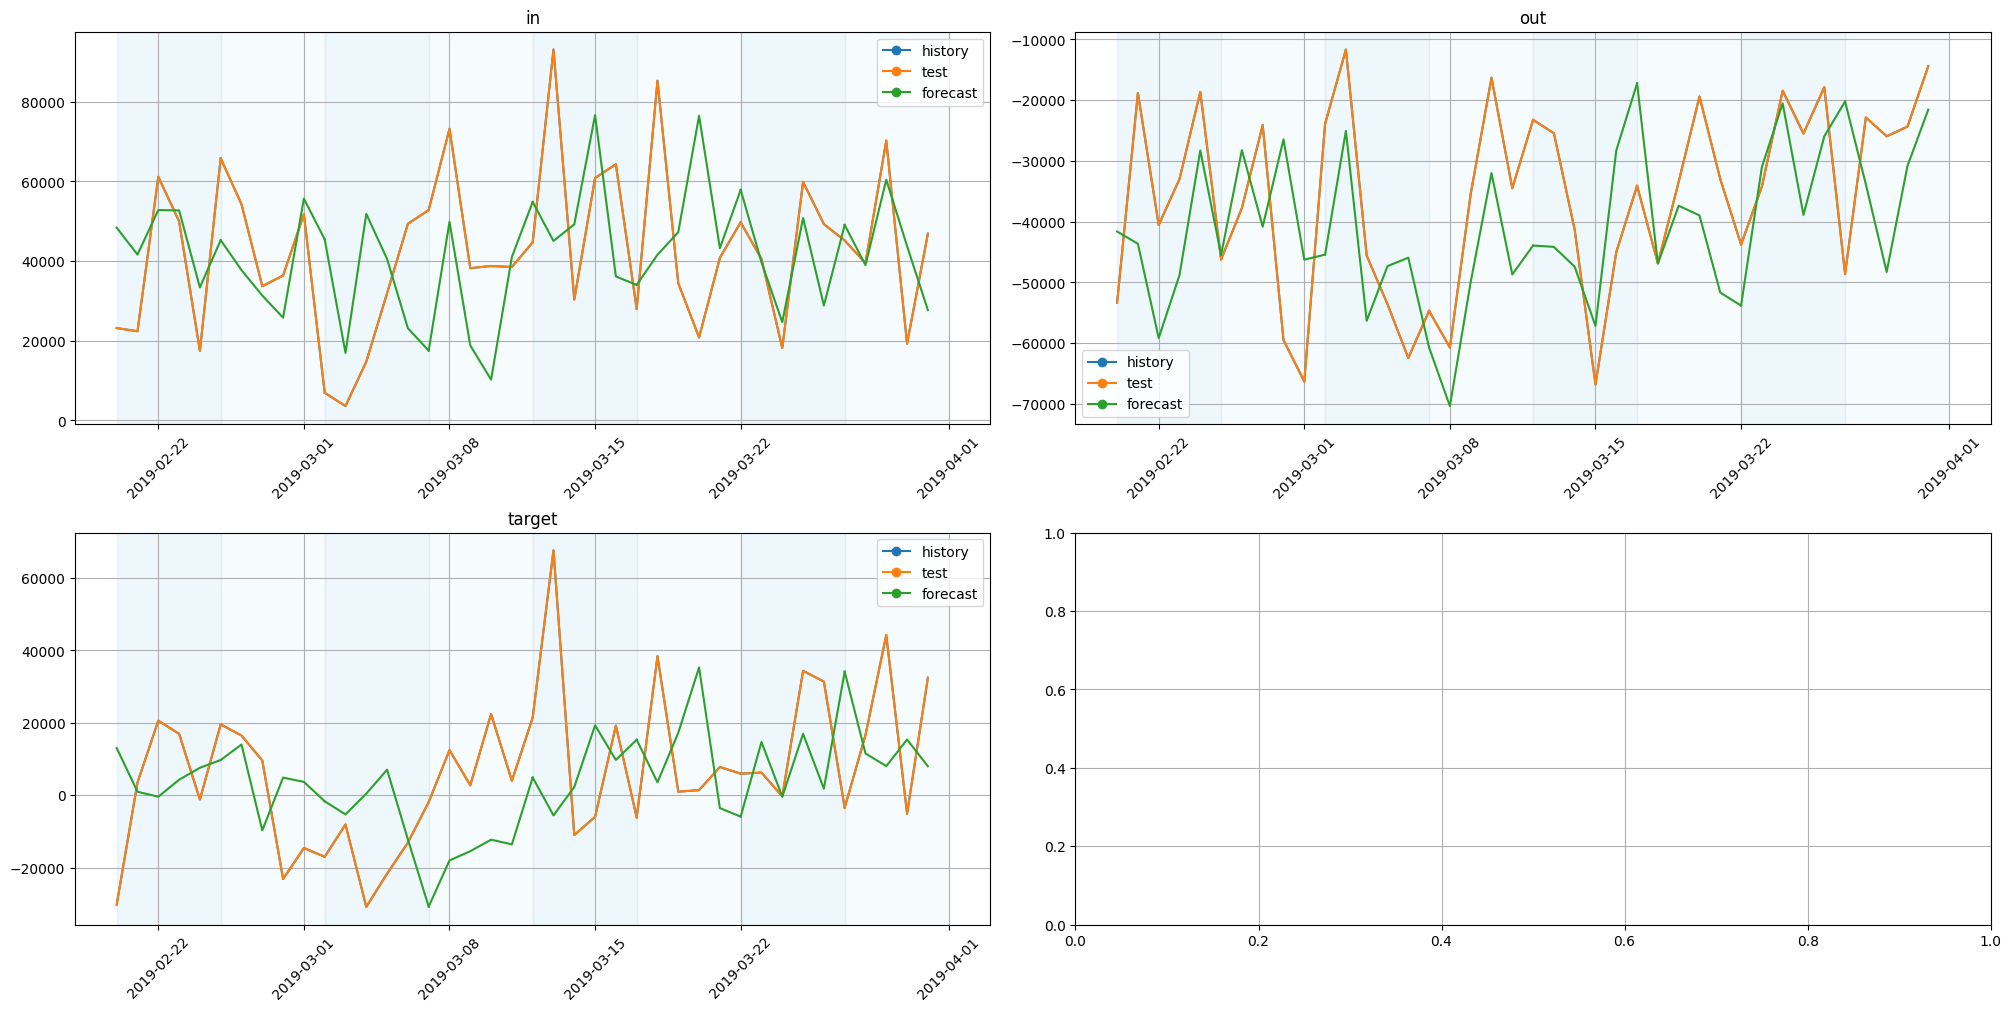

In [221]:
plot_backtest(forecast_df, ts_final)

### Задание 7. Стратегии прогнозирования (1.25 балла)

Как нам известно по семинарским занятиям, при построении прогноза на горизонте дальше следующего наблюдения перед нами встает задача определиться со стратегией генерации прогноза. Попробуйте разные стратегии на нашем горизонте из 5 дней (прямая, рекурсивная, смешанная dirrec). Какая стратегия в совокупности с какой моделью дает лучший результат?

Учитывайте особенности, которые некоторые стратегии могут накладывать на признаки (в частности, на лаговые переменные).

При необходимости, в смешанном методе пользуйтесь упрощенной схемой спецификации моделей/преобразований.

In [222]:
from etna.pipeline import AutoRegressivePipeline, Pipeline, assemble_pipelines
from etna.ensembles import DirectEnsemble

In [223]:
arpipeline = AutoRegressivePipeline(
    model=CatBoostModelPerSegment(), 
    transforms=[LagTransform(in_column="target", lags=[7,14,21,28,30,31]), SegmentEncoderTransform()], 
    horizon=HORIZON,
    step=1
)

In [224]:
%%capture
metrics_df, forecast_df, fold_info_df = arpipeline.backtest(
    ts=ts_final,
    metrics=[MAE(), SMAPE()],
    n_folds=8,
    aggregate_metrics=True,
)

In [225]:
metrics_df

segment           MAE       SMAPE
0      in  14458.935560   39.606060
1     out  13018.180702   36.981032
2  target  18006.103209  148.455694

In [226]:
direns = DirectEnsemble(pipelines=[
    Pipeline(
      model=CatBoostModelPerSegment(), 
      transforms=[LagTransform(in_column="target", lags=[7,14,21,28,30,31]), SegmentEncoderTransform()], 
      horizon=HORIZON
    ),
    Pipeline(
      model=CatBoostModelPerSegment(), 
      transforms=[LagTransform(in_column="target", lags=[7,14,21,28,30,31]), SegmentEncoderTransform()], 
      horizon=HORIZON*2
    )
  ]
)

In [227]:
%%capture
metrics_df, forecast_df, fold_info_df = direns.backtest(
    ts=ts_final,
    metrics=[MAE(), SMAPE()],
    n_folds=8,
    aggregate_metrics=True
)

In [228]:
metrics_df

segment           MAE       SMAPE
0      in  16607.797014   46.523621
1     out  12086.179071   36.940221
2  target  16442.462643  136.786496

DirectEnsemble даёт хорошие результаты, попробую другие модели с ним

In [229]:
%%capture 
ens2 = DirectEnsemble(pipelines=[
    Pipeline(model=AutoARIMAModel(), 
      transforms=[STLTransform(in_column="target", period=7), SegmentEncoderTransform()], 
      horizon=HORIZON),

    Pipeline(model=AutoARIMAModel(), 
      transforms=[STLTransform(in_column="target", period=7), SegmentEncoderTransform()], 
      horizon=HORIZON*2)])


metrics_df, forecast_df, fold_info_df = ens2.backtest(
    ts=ts_final,
    metrics=[MAE(), SMAPE()],
    n_folds=8,
    aggregate_metrics=True
)

In [230]:
metrics_df

segment           MAE       SMAPE
0      in  17730.966422   46.090297
1     out  14360.539578   41.822063
2  target  16935.496204  133.846905

In [231]:
%%capture
ens3 = DirectEnsemble(pipelines=[
    Pipeline(model=CatBoostMultiSegmentModel(), 
    transforms=[STLTransform(in_column="target", period=7), SegmentEncoderTransform()], 
    horizon=HORIZON),

    Pipeline(model=CatBoostMultiSegmentModel(), 
    transforms=[STLTransform(in_column="target", period=7), SegmentEncoderTransform()], 
    horizon=HORIZON*2)])
 
metrics_df, forecast_df, fold_info_df = ens3.backtest(
    ts=ts_final,
    metrics=[MAE(), SMAPE()],
    n_folds=8,
    aggregate_metrics=True
)

In [232]:
metrics_df

segment           MAE       SMAPE
0      in  17466.622670   45.546722
1     out  14307.381139   41.780107
2  target  16921.928552  134.012718

Лучше всего показывает себя ARIMA, ей я и буду присваивать наибольшие веса в дальнейшем

### Задание 8. Ансамбли (1.25 балла)

Чтобы не выбирать лучшую модель, мы можем использовать преимущества каждой - давайте объединим все наши наработки в ансамбль. Попробуйте различные опции ансамблирования, и выберите ту, которая работает лучше всего (не забывайте, что внутри каждого ансамбля у нас тоже есть параметры, которые мы можем варьировать - веса в voting, включаемые признаки в stacking).

In [233]:
from etna.ensembles import StackingEnsemble, VotingEnsemble

Пробую настакать DirectEnsemble с разными моделями в один ансамбль

In [234]:
catmult_pipeline =  DirectEnsemble(pipelines=[
    Pipeline(model=CatBoostMultiSegmentModel(), 
    transforms=[STLTransform(in_column="target", period=7), SegmentEncoderTransform()], 
    horizon=HORIZON),

    Pipeline(model=CatBoostMultiSegmentModel(), 
    transforms=[STLTransform(in_column="target", period=7), SegmentEncoderTransform()], 
    horizon=HORIZON*2)])


catpers_pipeline =  DirectEnsemble(pipelines=[
    Pipeline(model=CatBoostModelPerSegment(), 
      transforms=[LagTransform(in_column="target", lags=[7,14,21,28,30,31]), SegmentEncoderTransform()], 
      horizon=HORIZON),

    Pipeline(model=CatBoostModelPerSegment(), 
      transforms=[LagTransform(in_column="target", lags=[7,14,21,28,30,31]), SegmentEncoderTransform()], 
      horizon=HORIZON*2)])

arima_pipeline = DirectEnsemble(pipelines=[
    Pipeline(model=AutoARIMAModel(), 
      transforms=[STLTransform(in_column="target", period=7), SegmentEncoderTransform()], 
      horizon=HORIZON),

    Pipeline(model=AutoARIMAModel(), 
      transforms=[STLTransform(in_column="target", period=7), SegmentEncoderTransform()], 
      horizon=HORIZON*2)])

pipelines = [catmult_pipeline, catpers_pipeline, arima_pipeline]

In [235]:
%%capture
ens1 = VotingEnsemble(
    pipelines=pipelines,
    weights=[0.35, 0.2, 0.45],
    n_folds=8
)

metrics_df, forecast_df, fold_info_df = ens1.backtest(
    ts=ts_final,
    metrics=[MAE(), SMAPE()],
    n_folds=8,
    aggregate_metrics=True
)

In [236]:
metrics_df

segment           MAE       SMAPE
0      in  15857.789085   42.224477
1     out  12827.335936   38.206682
2  target  16327.152330  134.144222

Странно, но получилось хуже, чем DirectEnsemble только на ARIMA. Можно попробовать сравнять веса модлей

In [237]:
%%capture
ens2 = VotingEnsemble(
    pipelines=pipelines,
    n_folds=8
)

metrics_df, forecast_df, fold_info_df = ens2.backtest(
    ts=ts_final,
    metrics=[MAE(), SMAPE()],
    n_folds=8,
    aggregate_metrics=True
)

In [238]:
metrics_df

segment           MAE       SMAPE
0      in  14977.116144   40.270573
1     out  12071.719811   36.356848
2  target  16146.072605  133.681367

Стало лучше, даже удалось обогнать по качеству простой DirectEnsemble с ARIMA. Пробую StackingEnsemble

In [239]:
%%capture
ens3 = StackingEnsemble(
    pipelines=pipelines,
    n_folds=8
)

metrics_df, forecast_df, fold_info_df = ens2.backtest(
    ts=ts_final,
    metrics=[MAE(), SMAPE()],
    n_folds=8,
    aggregate_metrics=True
)

In [240]:
metrics_df

segment           MAE       SMAPE
0      in  14977.116144   40.270573
1     out  12071.719811   36.356848
2  target  16146.072605  133.681367

Результат не изменился. Получается этот и предыдущий ансамбли дают лучший результат из всего, что было рассмотрено в этой тетрадке

### Задание 9*. Трансформер (бонус 2 балла)

Для желающих протестировать мощь трансформенных моделей предлагается "завести" модель из второго семинара по временным рядам на текущем датасете. На этот раз абсолютно все необходимые импорты и зависимости подгружаются на ваше усмотрение. Удалось ли вам улучшить качество по сравнению с классическими моделями / моделями на основе ML? Что бы вы предпочли внедрить в production?

*NB:* все, конечно, прекрасно знают механизм работы бонусных заданий, но порядка ряди прописать дисклеймер должны - итоговый балл за домашнее задание ставится по формуле min(10, ваш суммарный балл за задания).

In [241]:
#YOUR CODE HERE#